In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
chem_raw=pd.read_csv('/Users/aatwood/Downloads/Full_Results_WRTDS_kalman_monthly.csv')

In [3]:
print(chem_raw['chemical'].unique())

['NOx' 'P' 'DSi' 'Si:P' 'NH4' 'DIN' 'Si:DIN' 'NO3']


In [4]:
def process_chem_data(chem_raw, id_cols, value_col='FNConc_mgL', pivot_col='chemical'):
    """
    More flexible version with column names
    
    Parameters:
    -----------
    chem_raw : pd.DataFrame
        Raw chemistry dataframe
    id_cols : list
        List of ID column names to keep
    value_col : str
        Column containing concentration values
    pivot_col : str
        Column to pivot (chemical names)
    """
    # Select specific columns
    cols_to_keep = id_cols + [pivot_col, value_col]
    chem_selected = chem_raw[cols_to_keep]
    
    # Pivot wider
    chem_wide = chem_selected.pivot_table(
        values=value_col,
        index=id_cols,
        columns=pivot_col,
        aggfunc='first'
    ).reset_index()
    
    # Create N column
    chem_wide['N'] = chem_wide.apply(
        lambda row: row['NO3'] if pd.isna(row['NOx']) 
                    else (row['NOx'] if pd.isna(row['NO3']) else np.nan),
        axis=1
    )
    
    # Select final columns (adjust as needed)
    final_cols = id_cols + ['N', 'DSi', 'P']  # Adjust based on what you want
    chem_wide = chem_wide[[col for col in final_cols if col in chem_wide.columns]]
    chem_wide['DSi:N']=chem_wide['DSi']/chem_wide['N']
    chem_wide['DSi:P']=chem_wide['DSi']/chem_wide['P']
    chem_wide['N:P']=chem_wide['N']/chem_wide['P']

    return chem_wide

# Usage example
id_columns = ['LTER', 'Stream_Name', 'Month', 'Year', 'drainSqKm', 'Discharge_cms']  # Replace with your actual ID columns
chem_wide = process_chem_data(chem_raw, id_cols=id_columns)

In [5]:
chem_wide_15 = (
    chem_wide.groupby('Stream_Name')
    .filter(lambda x: x['Year'].nunique() >= 15)
)
streams=chem_wide_15['Stream_Name'].unique()
constituents = ['N', 'P', 'DSi', 'DSi:N', 'DSi:P', 'N:P']

# Generate colors that go from cool (winter) to warm (summer) to cool (winter)
month_positions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0]
MONTH_COLORS = {
    1: '#3182bd',   # January - dark blue (winter)
    2: '#6baed6',   # February - medium blue
    3: '#9ecae1',   # March - light blue (spring)
    4: '#c6dbef',   # April - very light blue
    5: '#a1d99b',   # May - light green
    6: '#74c476',   # June - green (summer starts)
    7: '#fd8d3c',   # July - orange (hot)
    8: '#e6550d',   # August - red-orange (hottest)
    9: '#fdae6b',   # September - light orange (cooling)
    10: '#fdd0a2',  # October - pale orange (fall)
    11: '#9ecae1',  # November - light blue (cooling)
    12: '#3182bd'   # December - dark blue (winter)
}
MONTH_NAMES = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

In [6]:
def plot_stream_constituents_v2(df, stream_name, constituents, output_dir='plots'):
    """
    Version with shared legend at bottom
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    stream_data = df[df['Stream_Name'] == stream_name].copy()
    
    if len(stream_data) == 0:
        print(f"No data for stream: {stream_name}")
        return
    # Define Redfield Ration lines for bottom row (indices 3, 4, 5)
    thresholds = {
        3: 1,   # First bottom plot
        4: 16,  # Second bottom plot
        5: 16   # Third bottom plot
    }
    # Create figure with more space for legend
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    #fig.suptitle(f'{stream_name} - Constituents Over Time', 
     #            fontsize=16, fontweight='bold', y=0.98)
    
    axes = axes.flatten()
    
    # Store handles and labels for shared legend
    handles, labels = None, None
    
    for idx, constituent in enumerate(constituents):
        ax = axes[idx]
        
        for month in range(1, 13):
            month_data = stream_data[stream_data['Month'] == month].copy()
            
            if len(month_data) > 0:
                month_data = month_data.sort_values('Year')
                
                ax.scatter(
                        month_data['Year'], 
                        month_data[constituent],
                        color=MONTH_COLORS[month],
                        label=MONTH_NAMES[month],
                        s=50,  # Size of dots
                        alpha=0.7
                    )
                
                # Capture handles and labels from first plot
                if idx == 0 and handles is None:
                    if month == 12:  # After all months plotted
                        handles, labels = ax.get_legend_handles_labels()
        
        ax.set_xlabel('Year', fontsize=11, fontweight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
        # Different y-axis labels for top vs bottom row
        if idx < 3:  # Top row (indices 0, 1, 2)
            ax.set_ylabel(f'{constituent} (mg/L)', fontsize=10)
        else:  # Bottom row (indices 3, 4, 5)
            ax.set_ylabel(constituent, fontsize=10)  # No units
        
        ax.set_title(constituent, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add horizontal threshold line for bottom row
        if idx in thresholds:
            ax.axhline(
                y=thresholds[idx], 
                color='darkgrey', 
                linestyle='--', 
                linewidth=2, 
                alpha=0.7,
                label=f'Threshold: {thresholds[idx]}'
            )
        
        # Only show legend on first subplot
        if idx == 0:
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), 
                     fontsize=8, frameon=True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    safe_name = stream_name.replace('/', '_').replace(' ', '_')
    plt.savefig(f'{output_dir}/{safe_name}_constituents.png', 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Saved plot for {stream_name}")

In [36]:
# Plot each stream
import matplotlib.pyplot as plt
for stream in streams:
    plot_stream_constituents_v2(
        chem_wide_15, 
        stream, 
        constituents, 
        output_dir='stream_constituent_plots'
    )

print(f"\n✓ Created {len(streams)} plots!")

✓ Saved plot for GSMACK
✓ Saved plot for GSWS01
✓ Saved plot for GSWS02
✓ Saved plot for GSWS06
✓ Saved plot for GSWS07
✓ Saved plot for GSWS08
✓ Saved plot for GSWS09
✓ Saved plot for GSWS10
✓ Saved plot for Imnavait Weir
✓ Saved plot for BARWON RIVER AT DANGAR BRIDGE WALGETT
✓ Saved plot for BARWON RIVER AT MUNGINDI
✓ Saved plot for BILLABONG CREEK AT DARLOT
✓ Saved plot for DARLING RIVER AT BOURKE TOWN
✓ Saved plot for DARLING RIVER AT BURTUNDY
✓ Saved plot for DARLING RIVER AT MENINDEE UPSTREAM WEIR 32
✓ Saved plot for MURRAY RIVER DOWNSTREAM YARRAWONGA WEIR
✓ Saved plot for PEEL RIVER AT UPSTREAM PARADISE WEIR
✓ Saved plot for Mbalmayo
✓ Saved plot for Messam
✓ Saved plot for Olama
✓ Saved plot for ALSEK RIVER ABOVE BATES RIVER IN KLUANE NATIONAL PARK
✓ Saved plot for BEAVER RIVER ABOVE HIGHWAY 1 IN GLACIER NATIONAL PARK
✓ Saved plot for KICKING HORSE RIVER AT FIELD IN YOHO NATIONAL PARK
✓ Saved plot for KOOTENAY RIVER ABOVE HIGHWAY 93 IN KOOTENAY NATIONAL PARK
✓ Saved plot for LI

In [7]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

ro.r('options(repos=c(CRAN="https://cloud.r-project.org"))')

# Import R utilities
utils = importr('utils')
base = importr('base')

# Install R SiZer package (run once)
utils.install_packages('SiZer')

# Load SiZer
sizer_pkg = importr('SiZer')



R callback write-console: trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.5/SiZer_0.1-8.tgz'
  
R callback write-console: Content type 'application/x-gzip'  
R callback write-console:  length 82540 bytes (80 KB)
  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callba


The downloaded binary packages are in
	/var/folders/t7/y1wr1p2d33s27zhc0snt07rh0000gp/T//Rtmp3DWk9B/downloaded_packages


In [9]:
def run_sizer_monthly(df, stream_name, constituent, output_dir='sizer_results'):
    """
    Run R's SiZer for each month using rpy2
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    stream_data = df[df['Stream_Name'] == stream_name].copy()
    
    results = {}
    
    print(f"\nAnalyzing: {stream_name} - {constituent}")
    print("="*60)
    
    for month in range(1, 13):
        month_data = stream_data[stream_data['Month'] == month].copy()
        month_data = month_data.sort_values('Year')
        
        if len(month_data) < 10:
            print(f"Month {month:2d}: Insufficient data (n={len(month_data)})")
            continue
        
        x = month_data['Year'].values
        y = month_data[constituent].values
        
        # Remove NaNs
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]
        
        if len(x_clean) < 10:
            print(f"Month {month:2d}: Insufficient non-NA data")
            continue
        
        # Convert to R vectors
        # Convert to R vectors using localconverter (new method)
        with localconverter(ro.default_converter + pandas2ri.converter):
            x_r = ro.FloatVector(x_clean)
            y_r = ro.FloatVector(y_clean)
        
        # Run SiZer in R
        try:
            sizer_result = sizer_pkg.SiZer(x_r, y_r)
            
            # Save plot
            safe_name = stream_name.replace('/', '_').replace(' ', '_')
            plot_file = os.path.join(output_dir, 
                                    f'{safe_name}_{constituent}_month{month:02d}.png')
            
            # Create R plot
            ro.r(f'png("{plot_file}", width=800, height=600)')
            ro.r('par(mfrow=c(2,1))')
            
            # Plot raw data
            ro.r.plot(x_r, y_r, main=f"Month {month} - Raw Data",
                     xlab="Year", ylab=constituent, pch=16)
            
            # Plot SiZer map
            sizer_pkg.plot_SiZer(sizer_result, 
                                main=f"Month {month} - SiZer Map")
            
            ro.r('dev.off()')
            
            results[month] = sizer_result
            print(f"Month {month:2d}: ✓ Complete")
            
        except Exception as e:
            print(f"Month {month:2d}: ✗ Error - {str(e)}")
            continue
    
    return results



# Run for all streams
for stream in chem_wide_15['Stream_Name'].unique():
    sizer_results = run_sizer_monthly(
        chem_wide_15, 
        stream, 
        'DSi:N',
        output_dir='sizer_monthly_results'
    )

{1: <rpy2.robjects.vectors.ListVector object at 0x30c401a00> [RTYPES.VECSXP]
R classes: ('SiZer',)
[FloatSexpVector, FloatSexpVector, FloatSexpVector]
  x.grid: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x30c41eac0> [RTYPES.REALSXP]
  h.grid: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x168facbc0> [RTYPES.REALSXP]
  slopes: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x168fc1840> [RTYPES.REALSXP], 2: <rpy2.robjects.vectors.ListVector object at 0x306d64700> [RTYPES.VECSXP]
R classes: ('SiZer',)
[FloatSexpVector, FloatSexpVector, FloatSexpVector]
  x.grid: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x168fc1840> [RTYPES.REALSXP]
  h.grid: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x168facac0> [RTYPES.REALSXP]
  slopes: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rin

In [8]:
# First, let's inspect the actual SiZer object structure
# Run this on ONE month to see what we're working with

stream_data = chem_wide_15[chem_wide_15['Stream_Name'] == 'GSWS01'].copy()
month_data = stream_data[stream_data['Month'] == 1].sort_values('Year')

x = month_data['Year'].values.astype(float)
y = month_data['DSi:N'].values.astype(float)

mask = ~(np.isnan(x) | np.isnan(y))
x_clean = x[mask]
y_clean = y[mask]

with localconverter(ro.default_converter + pandas2ri.converter):
    x_r = ro.FloatVector(x_clean.tolist())
    y_r = ro.FloatVector(y_clean.tolist())

sizer_result = sizer_pkg.SiZer(x_r, y_r)
ro.r.assign('sizer_temp', sizer_result)

# Print everything about the object so we know exactly what's in it
print("Names:", list(sizer_result.names))
print("\n--- x.grid ---")
print("Length:", len(ro.r('sizer_temp$x.grid')))
print("Values:", np.array(ro.r('sizer_temp$x.grid')))

print("\n--- h.grid ---")
print("Length:", len(ro.r('sizer_temp$h.grid')))
print("Values:", np.array(ro.r('sizer_temp$h.grid')))

print("\n--- slopes ---")
print("Class:", ro.r('class(sizer_temp$slopes)'))
print("Dim:", ro.r('dim(sizer_temp$slopes)'))
print("Length:", ro.r('length(sizer_temp$slopes)'))
print("Str:", ro.r('str(sizer_temp$slopes)'))

# Try extracting slopes directly in R and printing
ro.r('''
    cat("\\nSlopes summary:\\n")
    print(summary(sizer_temp$slopes))
    cat("\\nFirst few values:\\n")
    print(head(sizer_temp$slopes, 20))
''')

Names: ['x.grid', 'h.grid', 'slopes']

--- x.grid ---
Length: 41
Values: [2003.  2003.4 2003.8 2004.2 2004.6 2005.  2005.4 2005.8 2006.2 2006.6
 2007.  2007.4 2007.8 2008.2 2008.6 2009.  2009.4 2009.8 2010.2 2010.6
 2011.  2011.4 2011.8 2012.2 2012.6 2013.  2013.4 2013.8 2014.2 2014.6
 2015.  2015.4 2015.8 2016.2 2016.6 2017.  2017.4 2017.8 2018.2 2018.6
 2019. ]

--- h.grid ---
Length: 41
Values: [ 1.          1.09050773  1.18920712  1.29683955  1.41421356  1.54221083
  1.68179283  1.83400809  2.          2.18101547  2.37841423  2.59367911
  2.82842712  3.08442165  3.36358566  3.66801617  4.          4.36203093
  4.75682846  5.18735822  5.65685425  6.1688433   6.72717132  7.33603235
  8.          8.72406186  9.51365692 10.37471644 11.3137085  12.3376866
 13.45434264 14.67206469 16.         17.44812372 19.02731384 20.74943287
 22.627417   24.67537321 26.90868529 29.34412938 32.        ]

--- slopes ---
Class: [1] "matrix" "array" 

Dim: [1] 41 41

Length: [1] 1681

 num [1:41, 1:41] 2 

In [15]:
"""
SiZer Workflow - Python Translation
====================================
Translated from R script for shifting-regime-stoich manuscript
Original: https://github.com/njlyon0/lter_silica-high-latitude/

Purpose:
    Run SiZer workflow on data produced by WRTDS
    WRTDS = Weighted Regressions on Time, Discharge, and Season
"""

import pandas as pd
import numpy as np
import os
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from scipy import stats

## ----------------------------------------- ##
# Housekeeping
## ----------------------------------------- ##

# Set CRAN mirror
ro.r('options(repos=c(CRAN="https://cloud.r-project.org"))')

# Load R packages
utils = importr('utils')
base = importr('base')

# Install SiZer if needed (run once)
# utils.install_packages('SiZer')
sizer_pkg = importr('SiZer')

# Make needed folders
os.makedirs('data', exist_ok=True)
os.makedirs('graphs', exist_ok=True)

## ----------------------------------------- ##
# General SiZer Prep
## ----------------------------------------- ##

# Temporal resolution of WRTDS output
# Must be one of: "annual", "seasonal", "monthly"
temporal_res = "monthly"

# Flexibly determine the needed resolution of WRTDS output
if temporal_res == "annual":
    wrtds_file = "Full_Results_WRTDS_annual.csv"
else:
    wrtds_file = "Full_Results_WRTDS_monthly.csv"

# Read in data
wrtds_v1 = chem_wide


# Minimum years of data required
MIN_YEARS = 15

def filter_data(df):
    """
    Remove unwanted data / data that don't meet needed criteria.
    Equivalent to the wrtds_v2 block in R.
    """


    # Calculate number of unique years per stream, keep only those >= MIN_YEARS
    num_years = (
        df.groupby(['LTER', 'Stream_Name'])['Year']
        .nunique()
        .reset_index(name='num_years')
    )
    df = df.merge(num_years, on=['LTER', 'Stream_Name'])
    df = df[df['num_years'] >= MIN_YEARS].drop(columns='num_years')

    return df.copy()


## ----------------------------------------- ##
# Unit Conversions & Tidying
## ----------------------------------------- ##

def tidy_units(df):
    """
    Convert 10^6 columns and tidy chemical names.
    Equivalent to the wrtds_v3 block in R.
    """
    df = df.copy()


    # Tidy chemical ratio names
    df = df.replace({
        'DSi:DIN': 'Si_N',
        'DSi:P': 'Si_P',
        'N:P': 'N_P'
    })

    # Rename Stream_Name -> stream
    df = df.rename(columns={'Stream_Name': 'stream'})

    return df


## ----------------------------------------- ##
# Month / Season Handling
## ----------------------------------------- ##

def add_month_season_if_missing(df, temporal_res):
    """
    If dataset is annual (no Month/season columns), add placeholder columns.
    Equivalent to the wrtds_v4 block in R.
    """
    df = df.copy()
    if 'Month' not in df.columns:
        df.insert(df.columns.get_loc('Year'), 'Month', 'x')
    if 'season' not in df.columns:
        df.insert(df.columns.get_loc('Year'), 'season', 'x')
    return df


def filter_mcm_months(df):
    """
    Remove months from McMurdo for which there shouldn't be data.
    Equivalent to the wrtds_v5 block in R.
    """
    df = df.copy()
    mcm_valid_months = ['x', 12, 1, 2]
    mask = (df['LTER'] != 'MCM') | (df['Month'].isin(mcm_valid_months))
    return df[mask].copy()


## ----------------------------------------- ##
# Variable Selection
## ----------------------------------------- ##

# Choose response / explanatory variables and focal chemical
response = "Yield"
explanatory = "Year"
elements = ['N', 'P', 'DSi', 'DSi:N', 'DSi:P', 'N:P']  # Update this to your actual column names


def select_focal_data_wide(df, elements):
    """
    Select ID columns + chemical columns.
    No longer filtering by a 'chemical' column - chemicals ARE the columns.
    """
    # ID columns (everything that isn't a chemical)
    id_cols = ['LTER', 'stream', 'drainSqKm', 'Month', 'season', 'Year']
    
    # Only keep chemicals that actually exist in the dataframe
    valid_elements = [e for e in elements if e in df.columns]
    
    if len(valid_elements) == 0:
        raise ValueError(f"None of {elements} found in dataframe. Available columns: {list(df.columns)}")
    
    print(f"  Valid elements found: {valid_elements}")
    
    keep_cols = [c for c in id_cols if c in df.columns] + valid_elements
    return df[keep_cols].copy()## ----------------------------------------- ##
# Core SiZer Workflow
## ----------------------------------------- ##

def run_sizer_on_series(x, y):
    """
    Run R's SiZer on a single x/y series.
    Returns the raw R SiZer object.
    """
    with localconverter(ro.default_converter + pandas2ri.converter):
        x_r = ro.FloatVector(x.tolist())
        y_r = ro.FloatVector(y.tolist())

    sizer_result = sizer_pkg.SiZer(x_r, y_r)
    return sizer_result


def extract_sizer_sections(sizer_result, x_data, y_data):
    """
    Extract section info (slope direction + breakpoints) from a SiZer object.
    Runs linear regression on each section to get slope estimates and stats.

    Returns:
    --------
    data_rows : list of dicts (section boundaries, slope type)
    stat_rows : list of dicts (F-stat, p-value, r-squared, etc.)
    est_rows  : list of dicts (slope estimate, std error, etc.)
    """
    ro.r.assign('sizer_temp', sizer_result)

    # Extract grid and slopes using R
    x_grid = np.array(ro.r('as.numeric(sizer_temp$x.grid)'))
    h_vals = np.array(ro.r('as.numeric(sizer_temp$h.grid)'))

    # Extract slopes matrix safely in R, then bring to Python
    ro.r('''
        slopes_mat <- sizer_temp$slopes
        if (is.matrix(slopes_mat)) {
            slopes_vec <- as.numeric(slopes_mat)
            slopes_dim <- dim(slopes_mat)
        } else {
            slopes_vec <- as.numeric(slopes_mat)
            slopes_dim <- c(length(slopes_mat), 1)
        }
    ''')

    slopes_raw = np.array(ro.r('slopes_vec'))
    slopes_dim = list(ro.r('slopes_dim'))
    n_rows = int(slopes_dim[0])
    n_cols = int(slopes_dim[1])

    # Reshape (R is column-major / Fortran order)
    slope_class = slopes_raw.reshape((n_rows, n_cols), order='F')

    # Use median bandwidth row
    median_idx = len(h_vals) // 2
    median_bw = h_vals[median_idx]
    slope_row = slope_class[median_idx, :]

    # Map slope classifications to labels
    slope_map = {1: 'increasing', 0: 'flat', -1: 'decreasing'}

    # Find breakpoints (where slope classification changes)
    changes = np.diff(slope_row)
    breakpoint_indices = np.where(changes != 0)[0]

    # Build segments: list of (start_idx, end_idx)
    boundaries = [0] + list(breakpoint_indices + 1) + [len(slope_row)]
    segments = list(zip(boundaries[:-1], boundaries[1:]))

    data_rows = []
    stat_rows = []
    est_rows = []

    for seg_start, seg_end in segments:
        # Year range for this segment
        year_start = x_grid[seg_start]
        year_end = x_grid[seg_end - 1]

        # Dominant slope in segment
        seg_slopes = slope_row[seg_start:seg_end]
        dominant_slope = slope_map.get(int(np.median(seg_slopes)), 'flat')

        # Filter original data to this segment
        mask = (x_data >= year_start) & (x_data <= year_end)
        x_seg = x_data[mask]
        y_seg = y_data[mask]

        # Section label
        if len(segments) == 1:
            section_label = "No inflection points"
        else:
            section_label = f"({year_start:.1f}, {year_end:.1f}]"

        # --- Data row ---
        data_rows.append({
            'sizer_bandwidth': median_bw,
            'section': section_label,
            'section_start': year_start,
            'section_end': year_end,
            'section_duration': year_end - year_start,
            'sizer_slope': dominant_slope
        })

        # --- Run linear regression on this segment for stats + estimates ---
        if len(x_seg) >= 2 and np.std(x_seg) > 0:
            slope_val, intercept, r_value, p_value, std_err = stats.linregress(x_seg, y_seg)

            n_obs = len(x_seg)
            y_pred = intercept + slope_val * x_seg
            ss_res = np.sum((y_seg - y_pred) ** 2)
            ss_tot = np.sum((y_seg - np.mean(y_seg)) ** 2)
            r_squared = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

            df_model = 1
            df_resid = n_obs - 2
            ms_res = ss_res / df_resid if df_resid > 0 else np.nan
            ms_model = (ss_tot - ss_res) / df_model if df_model > 0 else np.nan
            f_stat = ms_model / ms_res if ms_res and ms_res > 0 else np.nan

            sigma = np.sqrt(ms_res) if ms_res else np.nan
            adj_r_squared = 1 - (1 - r_squared) * (n_obs - 1) / (n_obs - 2) if n_obs > 2 else np.nan

            # Log-likelihood (assuming normal residuals)
            log_lik = -n_obs / 2 * (np.log(2 * np.pi * ms_res) + 1) if ms_res and ms_res > 0 else np.nan

            # AIC / BIC
            k = 2  # number of parameters (slope + intercept)
            aic = 2 * k - 2 * log_lik if not np.isnan(log_lik) else np.nan
            bic = k * np.log(n_obs) - 2 * log_lik if not np.isnan(log_lik) else np.nan

            # Deviance (= SS_res for linear models)
            deviance = ss_res

            # --- Statistic row ---
            stat_rows.append({
                'sizer_bandwidth': median_bw,
                'section': section_label,
                'F_statistic': f_stat,
                'test_p_value': p_value,
                'r_squared': r_squared,
                'adj_r_squared': adj_r_squared,
                'sigma': sigma,
                'df': df_model,
                'df_residual': df_resid,
                'nobs': n_obs,
                'logLik': log_lik,
                'AIC': aic,
                'BIC': bic,
                'deviance': deviance
            })

            # --- Estimate row ---
            est_rows.append({
                'sizer_bandwidth': median_bw,
                'section': section_label,
                'slope_estimate': slope_val,
                'slope_std_error': std_err
            })
        else:
            # Not enough data to regress
            stat_rows.append({
                'sizer_bandwidth': median_bw,
                'section': section_label,
                'F_statistic': np.nan, 'test_p_value': np.nan,
                'r_squared': np.nan, 'adj_r_squared': np.nan,
                'sigma': np.nan, 'df': np.nan, 'df_residual': np.nan,
                'nobs': len(x_seg), 'logLik': np.nan,
                'AIC': np.nan, 'BIC': np.nan, 'deviance': np.nan
            })
            est_rows.append({
                'sizer_bandwidth': median_bw,
                'section': section_label,
                'slope_estimate': np.nan,
                'slope_std_error': np.nan
            })

    return data_rows, stat_rows, est_rows


def run_sizer_monthly_loop(df, elements, temporal_res, explanatory='Year'):
    """
    Core SiZer loop for WIDE format data.
    Loops over: streams -> chemicals -> months/seasons

    Parameters:
    -----------
    df : pd.DataFrame
        Wide-format dataframe where each chemical is its own column
    elements : list
        List of chemical column names to analyze
    temporal_res : str
        'annual', 'seasonal', or 'monthly'
    explanatory : str
        Column name for x-axis (usually 'Year')
    """
    data_list = []
    statistic_list = []
    estimate_list = []

    streams = df['stream'].unique()
    valid_elements = [e for e in elements if e in df.columns]

    for place in streams:
        print(f"\nProcessing: {place}")
        wrtds_place = df[df['stream'] == place].copy()

        # Loop over each chemical
        for element in valid_elements:
            print(f"  Chemical: {element}")

            if temporal_res == "annual":
                focal_month = 'x'
                focal_season = 'x'

                x = wrtds_place[explanatory].values.astype(float)
                y = wrtds_place[element].values.astype(float)

                mask = ~(np.isnan(x) | np.isnan(y))
                x_clean, y_clean = x[mask], y[mask]

                if len(x_clean) < 5:
                    print(f"    Skipping: insufficient data (n={len(x_clean)})")
                    continue

                try:
                    sizer_result = run_sizer_on_series(x_clean, y_clean)
                    d_rows, s_rows, e_rows = extract_sizer_sections(sizer_result, x_clean, y_clean)

                    for row in d_rows:
                        row.update({
                            'LTER': wrtds_place['LTER'].iloc[0],
                            'stream': place,
                            'drainSqKm': wrtds_place['drainSqKm'].iloc[0],
                            'chemical': element,
                            'Month': focal_month,
                            'season': focal_season
                        })
                        data_list.append(row)

                    for row in s_rows:
                        row.update({'stream': place, 'chemical': element,
                                    'Month': focal_month, 'season': focal_season})
                        statistic_list.append(row)

                    for row in e_rows:
                        row.update({'stream': place, 'chemical': element,
                                    'Month': focal_month, 'season': focal_season})
                        estimate_list.append(row)

                except Exception as e:
                    print(f"    Error: {e}")

            elif temporal_res == "seasonal":
                focal_month = 'x'

                # Average by season
                wrtds_place_v2 = (
                    wrtds_place.dropna(subset=['season'])
                    .groupby(['LTER', 'stream', 'drainSqKm', 'season', 'Year'])
                    .agg({element: 'mean'})
                    .reset_index()
                )

                for focal_season in wrtds_place_v2['season'].unique():
                    print(f"    Season: {focal_season}")
                    wrtds_core = wrtds_place_v2[wrtds_place_v2['season'] == focal_season].copy()

                    x = wrtds_core[explanatory].values.astype(float)
                    y = wrtds_core[element].values.astype(float)

                    mask = ~(np.isnan(x) | np.isnan(y))
                    x_clean, y_clean = x[mask], y[mask]

                    if len(x_clean) < 5:
                        continue

                    try:
                        sizer_result = run_sizer_on_series(x_clean, y_clean)
                        d_rows, s_rows, e_rows = extract_sizer_sections(sizer_result, x_clean, y_clean)

                        for row in d_rows:
                            row.update({
                                'LTER': wrtds_core['LTER'].iloc[0],
                                'stream': place,
                                'drainSqKm': wrtds_core['drainSqKm'].iloc[0],
                                'chemical': element,
                                'Month': focal_month,
                                'season': focal_season
                            })
                            data_list.append(row)

                        for row in s_rows:
                            row.update({'stream': place, 'chemical': element,
                                        'Month': focal_month, 'season': focal_season})
                            statistic_list.append(row)

                        for row in e_rows:
                            row.update({'stream': place, 'chemical': element,
                                        'Month': focal_month, 'season': focal_season})
                            estimate_list.append(row)

                    except Exception as e:
                        print(f"      Error: {e}")

            elif temporal_res == "monthly":
                focal_season = 'x'

                # Average by month
                wrtds_place_v2 = (
                    wrtds_place.dropna(subset=['Month'])
                    .groupby(['LTER', 'stream', 'drainSqKm', 'Month', 'Year'])
                    .agg({element: 'mean'})
                    .reset_index()
                )

                for focal_month in wrtds_place_v2['Month'].unique():
                    print(f"    Month: {focal_month}")
                    wrtds_core = wrtds_place_v2[wrtds_place_v2['Month'] == focal_month].copy()

                    x = wrtds_core[explanatory].values.astype(float)
                    y = wrtds_core[element].values.astype(float)

                    mask = ~(np.isnan(x) | np.isnan(y))
                    x_clean, y_clean = x[mask], y[mask]

                    if len(x_clean) < 5:
                        continue

                    try:
                        sizer_result = run_sizer_on_series(x_clean, y_clean)
                        d_rows, s_rows, e_rows = extract_sizer_sections(sizer_result, x_clean, y_clean)

                        for row in d_rows:
                            row.update({
                                'LTER': wrtds_core['LTER'].iloc[0],
                                'stream': place,
                                'drainSqKm': wrtds_core['drainSqKm'].iloc[0],
                                'chemical': element,
                                'Month': focal_month,
                                'season': focal_season
                            })
                            data_list.append(row)

                        for row in s_rows:
                            row.update({'stream': place, 'chemical': element,
                                        'Month': focal_month, 'season': focal_season})
                            statistic_list.append(row)

                        for row in e_rows:
                            row.update({'stream': place, 'chemical': element,
                                        'Month': focal_month, 'season': focal_season})
                            estimate_list.append(row)

                    except Exception as e:
                        print(f"      Error: {e}")

            else:
                raise ValueError("Use 'annual', 'seasonal', or 'monthly'")

    return data_list, statistic_list, estimate_list

## ----------------------------------------- ##
# Process Outputs
## ----------------------------------------- ##

def process_outputs(data_list, statistic_list, estimate_list, response):
    """
    Process the three output lists into clean DataFrames.
    Equivalent to the 'Process Outputs' block in R.
    """
    # --- data_actual ---
    data_actual = pd.DataFrame(data_list).drop_duplicates()

    # --- statistic_actual ---
    statistic_actual = pd.DataFrame(statistic_list).drop_duplicates()

    # --- estimate_actual ---
    estimate_actual = pd.DataFrame(estimate_list).drop_duplicates()

    return data_actual, statistic_actual, estimate_actual


## ----------------------------------------- ##
# Combine Outputs
## ----------------------------------------- ##

def combine_outputs(data_actual, statistic_actual, estimate_actual, df_original, elements):
    """
    Updated for wide format - pulls actual response values from original df
    to calculate mean_response and percent_change per section.
    """
    # Join stats and estimates
    join_keys = ['sizer_bandwidth', 'stream', 'section', 'season', 'Month', 'chemical']
    
    combo = data_actual.merge(statistic_actual, on=join_keys, how='left')
    combo = combo.merge(estimate_actual, on=join_keys, how='left')

    # Fix types
    numeric_cols = ['sizer_bandwidth', 'r_squared', 'adj_r_squared', 'sigma',
                    'df', 'df_residual', 'nobs', 'logLik', 'AIC', 'BIC',
                    'deviance', 'F_statistic', 'test_p_value',
                    'slope_estimate', 'slope_std_error',
                    'section_start', 'section_end', 'section_duration']
    for col in numeric_cols:
        if col in combo.columns:
            combo[col] = pd.to_numeric(combo[col], errors='coerce')

    # --- LTER_stream label ---
    combo['LTER_simp'] = combo['LTER'].apply(lambda x: x if len(str(x)) <= 4 else str(x)[:4])
    combo['site_simp'] = combo['stream'].apply(lambda x: str(x).replace(' at', ' '))
    combo['site_simp'] = combo['site_simp'].apply(lambda x: x if len(x) <= 14 else x[:14])
    combo['LTER_stream'] = combo['LTER_simp'] + '_' + combo['site_simp']
    combo = combo.drop(columns=['LTER_simp', 'site_simp'])

    # --- Calculate mean_response per section from original wide data ---
    # For each row in combo, look up the actual values from df_original
    # based on stream, chemical, and year range (section_start to section_end)
    mean_responses = []
    sd_responses = []

    for _, row in combo.iterrows():
        stream_mask = df_original['stream'] == row['stream']
        year_mask = (df_original['Year'] >= row['section_start']) & \
                    (df_original['Year'] <= row['section_end'])
        
        chemical = row['chemical']
        
        if chemical in df_original.columns:
            values = df_original.loc[stream_mask & year_mask, chemical].dropna()
            mean_responses.append(values.mean() if len(values) > 0 else np.nan)
            sd_responses.append(values.std() if len(values) > 0 else np.nan)
        else:
            mean_responses.append(np.nan)
            sd_responses.append(np.nan)

    combo['mean_response'] = mean_responses
    combo['sd_response'] = sd_responses
    combo['percent_change'] = (combo['slope_estimate'] / combo['mean_response']) * 100

    return combo


## ----------------------------------------- ##
# Export
## ----------------------------------------- ##

def export_results(combo, temporal_res, response, element):
    """
    Save final combined output to CSV.
    """
    # Rename stream -> Stream_Name for export
    combo_export = combo.rename(columns={'stream': 'Stream_Name'})

    # Create output folder
    data_outs = f"sizer-outs_{temporal_res}"
    os.makedirs(os.path.join('data', data_outs), exist_ok=True)

    # Output filename
    graph_outs = f"{temporal_res}_{response}_{element}"
    out_file = os.path.join('data', data_outs, f"sizer-outs_{graph_outs}.csv")

    combo_export.to_csv(out_file, index=False)
    print(f"\n✓ Results exported to: {out_file}")
    print(f"  Rows: {len(combo_export)}")
    print(f"  Columns: {list(combo_export.columns)}")

    return out_file


## ----------------------------------------- ##
# MAIN: Run everything
## ----------------------------------------- ##

if __name__ == "__main__":

    # --- 1. Filter ---
    print("Step 1: Filtering data...")
    wrtds_v2 = filter_data(wrtds_v1)

    # --- 2. Tidy ---
    print("\nStep 2: Tidying units...")
    wrtds_v3 = tidy_units(wrtds_v2)

    # --- 3. Add Month/Season if missing ---
    print("\nStep 3: Ensuring Month/season columns exist...")
    wrtds_v4 = add_month_season_if_missing(wrtds_v3, temporal_res)

    # --- 4. McMurdo filter ---
    print("\nStep 4: Filtering McMurdo months...")
    wrtds_v5 = filter_mcm_months(wrtds_v4)

    # --- 5. Select focal data (WIDE format) ---
    print(f"\nStep 5: Selecting chemicals: {elements}")
    wrtds_focal = select_focal_data_wide(wrtds_v5, elements)
    print(f"  Focal rows: {len(wrtds_focal)}")
    print(f"  Streams: {wrtds_focal['stream'].nunique()}")
    print(f"  Columns: {list(wrtds_focal.columns)}")
    #test_streams = wrtds_focal['stream'].unique()[:10]
    #wrtds_focal = wrtds_focal[wrtds_focal['stream'].isin(test_streams)].copy()

    #print(f"  Testing on {len(test_streams)} streams:")
    #for s in test_streams:
        #print(f"    - {s}")

    # --- 6. Create output folders ---
    data_outs = f"sizer-outs_{temporal_res}"
    os.makedirs(os.path.join('data', data_outs), exist_ok=True)
    os.makedirs(os.path.join('graphs', f"{temporal_res}_all_elements"), exist_ok=True)

    # --- 7. Core SiZer loop (now loops over chemicals too) ---
    print(f"\nStep 6: Running SiZer loop ({temporal_res}, {len(elements)} chemicals)...")
    data_list, statistic_list, estimate_list = run_sizer_monthly_loop(
        wrtds_focal, elements, temporal_res
    )

    # --- 8. Process outputs ---
    print("\nStep 7: Processing outputs...")
    data_actual, statistic_actual, estimate_actual = process_outputs(
        data_list, statistic_list, estimate_list, response=None
    )

    # --- 9. Combine (pass original df for mean_response lookup) ---
    print("\nStep 8: Combining outputs...")
    combo_final = combine_outputs(
        data_actual, statistic_actual, estimate_actual,
        df_original=wrtds_focal,
        elements=elements
    )
    print(combo_final.head(10))

    # --- 10. Uniqueness check ---
    raw_unique = (combo_final['LTER'] + combo_final['stream']).nunique()
    lter_stream_unique = combo_final['LTER_stream'].nunique()
    print(f"\n  Raw LTER+stream unique: {raw_unique}")
    print(f"  LTER_stream unique:     {lter_stream_unique}")
    if raw_unique != lter_stream_unique:
        print("  ⚠ WARNING: LTER_stream not fully unique - check truncation!")

    # --- 11. Export ---
    print("\nStep 9: Exporting...")
    combo_export = combo_final.rename(columns={'stream': 'Stream_Name'})
    out_file = os.path.join('data', data_outs, f"sizer-outs_{temporal_res}_all_elements.csv")
    combo_export.to_csv(out_file, index=False)
    print(f"✓ Exported to: {out_file}")

    print("\n✓ Done!")

Step 1: Filtering data...

Step 2: Tidying units...

Step 3: Ensuring Month/season columns exist...

Step 4: Filtering McMurdo months...

Step 5: Selecting chemicals: ['N', 'P', 'DSi', 'DSi:N', 'DSi:P', 'N:P']
  Valid elements found: ['N', 'P', 'DSi', 'DSi:N', 'DSi:P', 'N:P']
  Focal rows: 288402
  Streams: 333
  Columns: ['LTER', 'stream', 'drainSqKm', 'Month', 'season', 'Year', 'N', 'P', 'DSi', 'DSi:N', 'DSi:P', 'N:P']

Step 6: Running SiZer loop (monthly, 6 chemicals)...

Processing: GSMACK
  Chemical: N
    Month: 1
    Month: 2
    Month: 3
    Month: 4
    Month: 5
    Month: 6
    Month: 7
    Month: 8
    Month: 9
    Month: 10
    Month: 11
    Month: 12
  Chemical: P
    Month: 1
    Month: 2
    Month: 3
    Month: 4
    Month: 5
    Month: 6
    Month: 7
    Month: 8
    Month: 9
    Month: 10
    Month: 11
    Month: 12
  Chemical: DSi
    Month: 1
    Month: 2
    Month: 3
    Month: 4
    Month: 5
    Month: 6
    Month: 7
    Month: 8
    Month: 9
    Month: 10
    Mont

In [16]:
print(combo_export)

       sizer_bandwidth           section  section_start  section_end  \
0             6.782330  (1996.0, 1997.7]       1996.000     1997.725   
1             6.782330  (1998.3, 2002.3]       1998.300     2002.325   
2             6.782330  (2002.9, 2011.0]       2002.900     2010.950   
3             6.782330  (2011.5, 2015.5]       2011.525     2015.550   
4             6.782330  (2016.1, 2019.0]       2016.125     2019.000   
...                ...               ...            ...          ...   
54662         6.928203  (1988.0, 1992.8]       1988.000     1992.800   
54663         6.928203  (1993.4, 2012.0]       1993.400     2012.000   
54664         6.928203  (1988.0, 1990.4]       1988.000     1990.400   
54665         6.928203  (1991.0, 1994.0]       1991.000     1994.000   
54666         6.928203  (1994.6, 2012.0]       1994.600     2012.000   

       section_duration sizer_slope           LTER Stream_Name  drainSqKm  \
0                 1.725  increasing            AND      GS

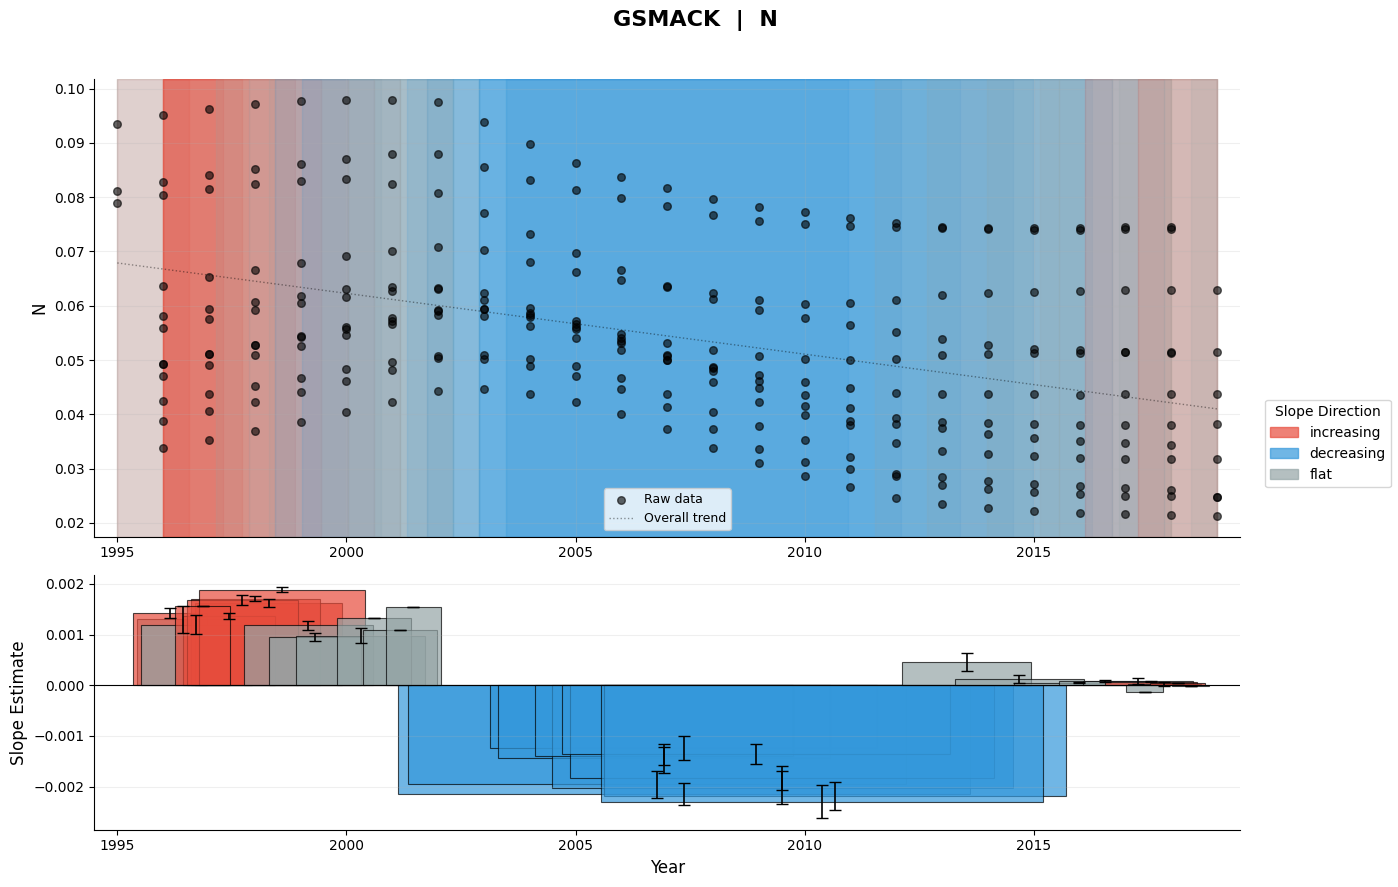

Plotting 28 stream-chemical combinations...
[1/28] GSMACK - N


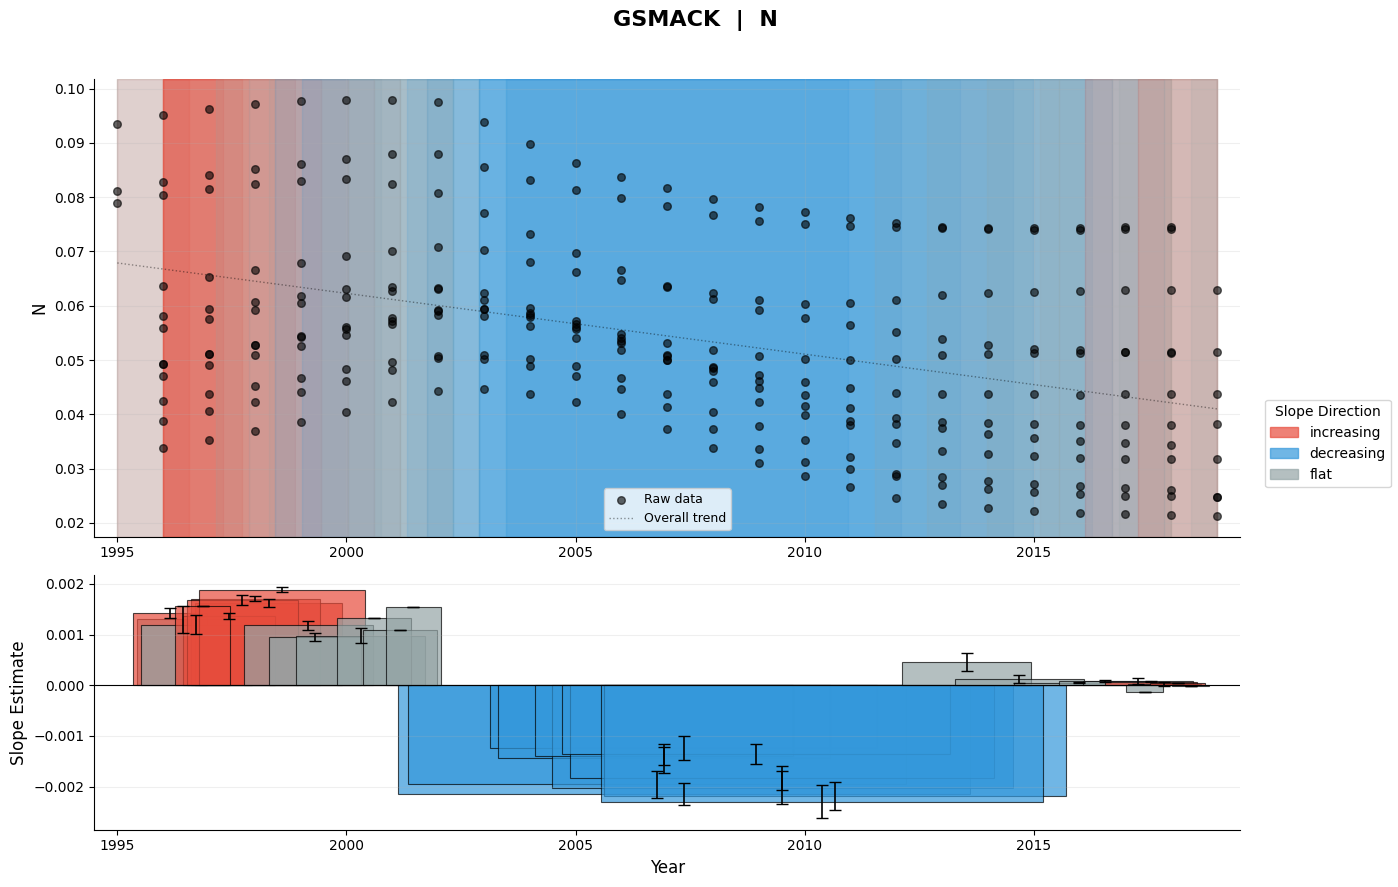

[2/28] GSMACK - P


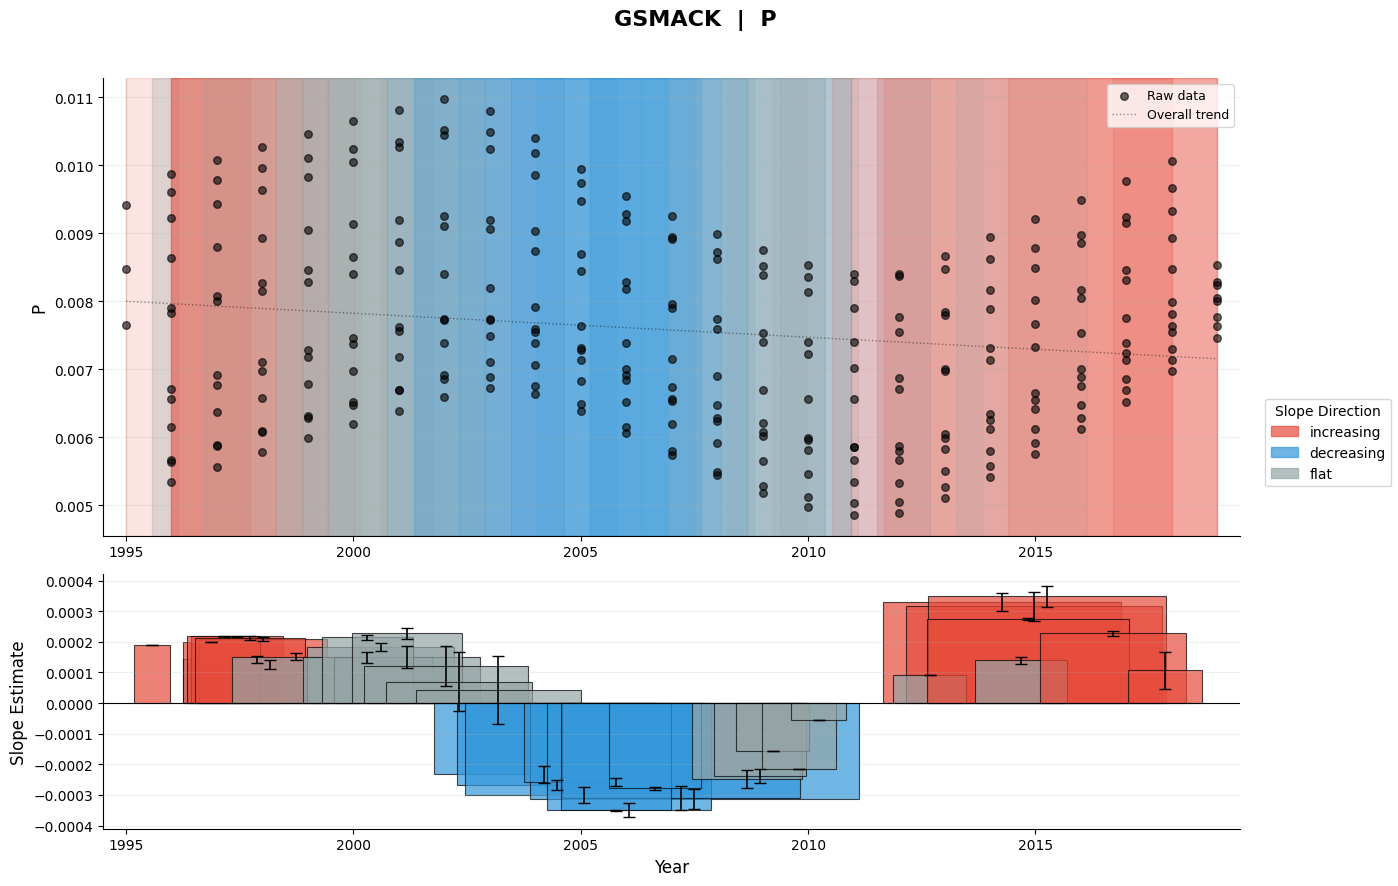

[3/28] GSMACK - N:P


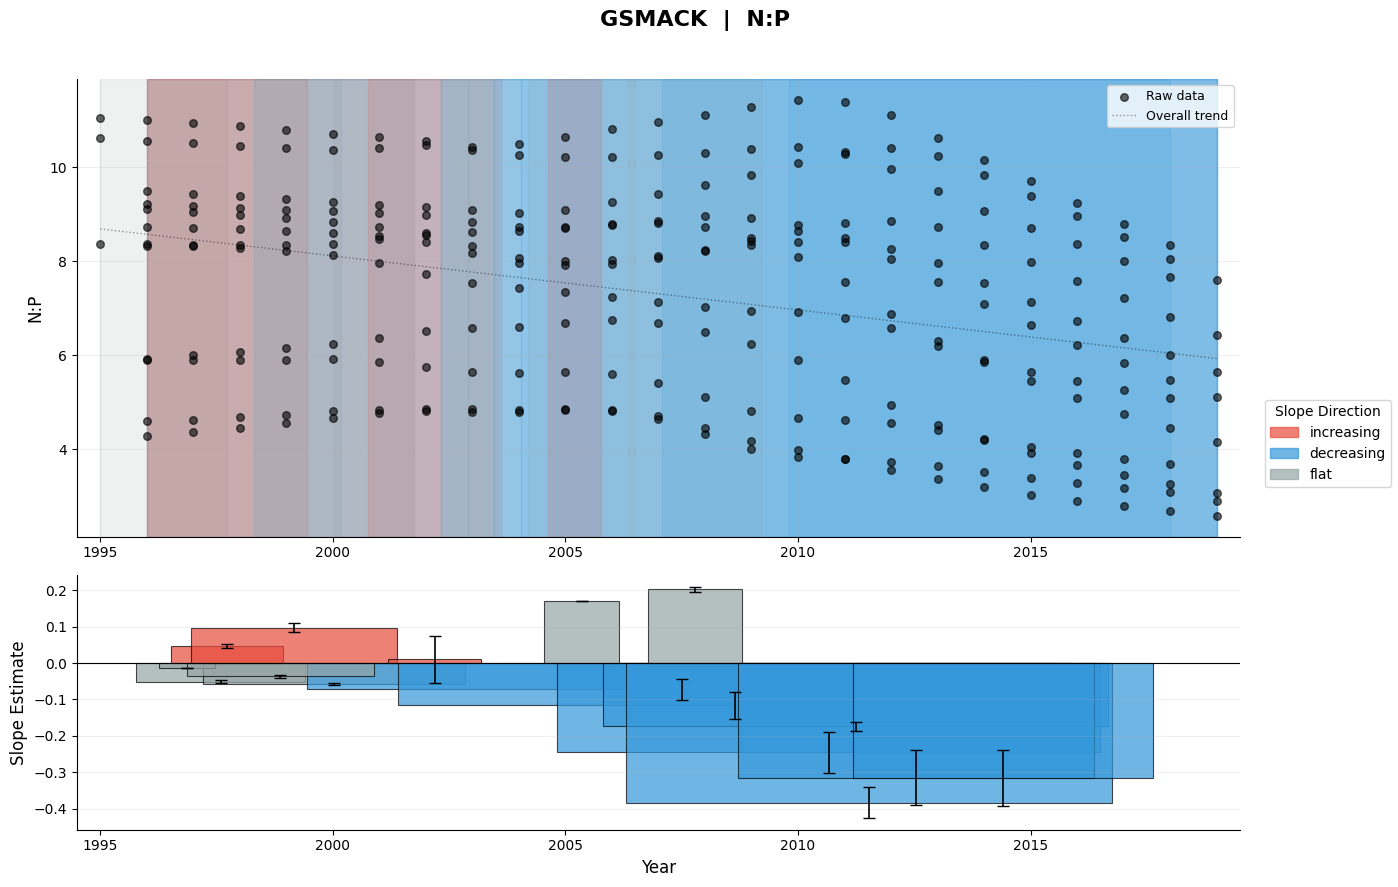

[4/28] GSWS01 - N


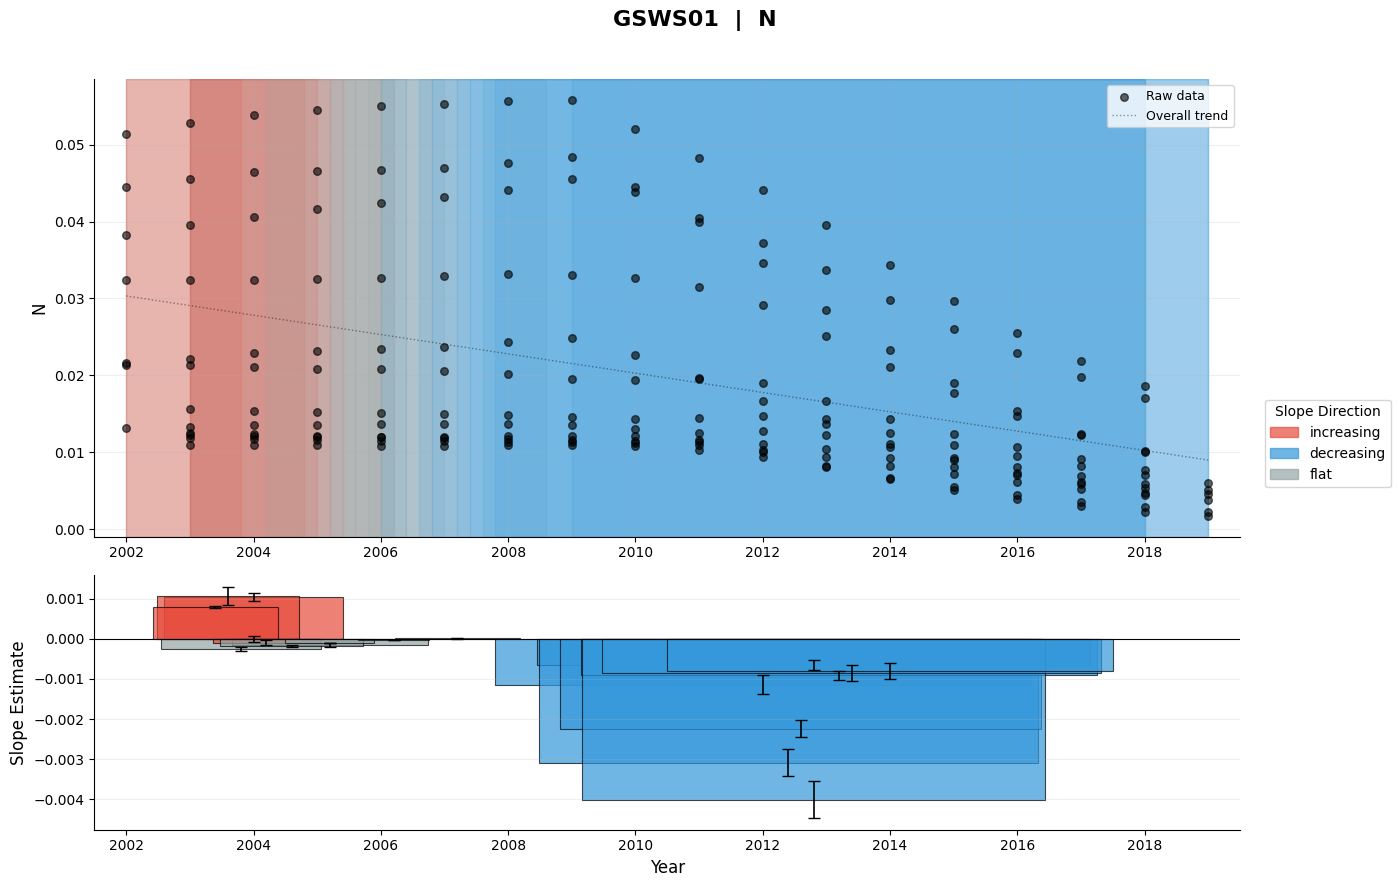

[5/28] GSWS01 - P


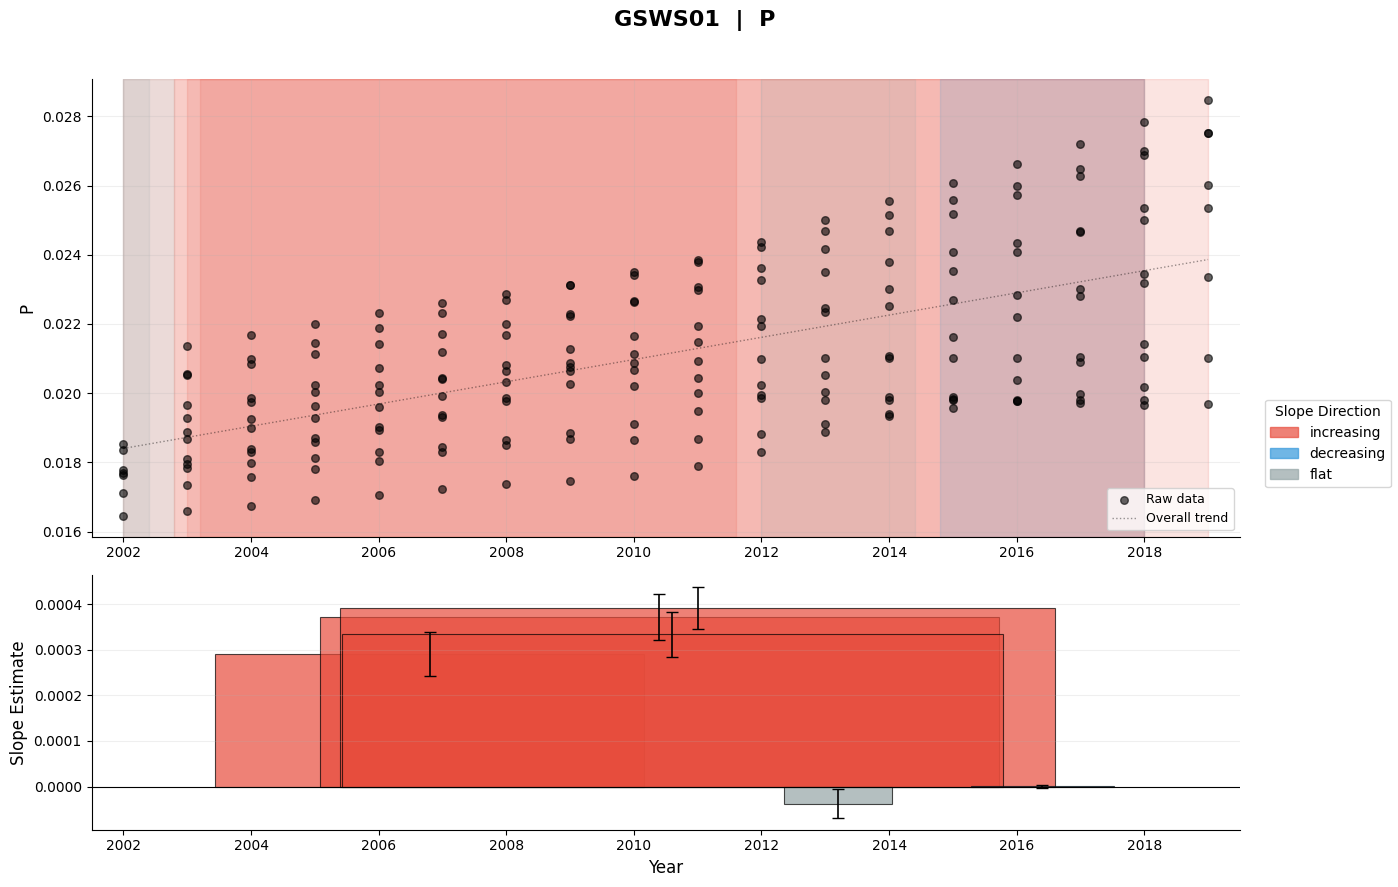

[6/28] GSWS01 - DSi


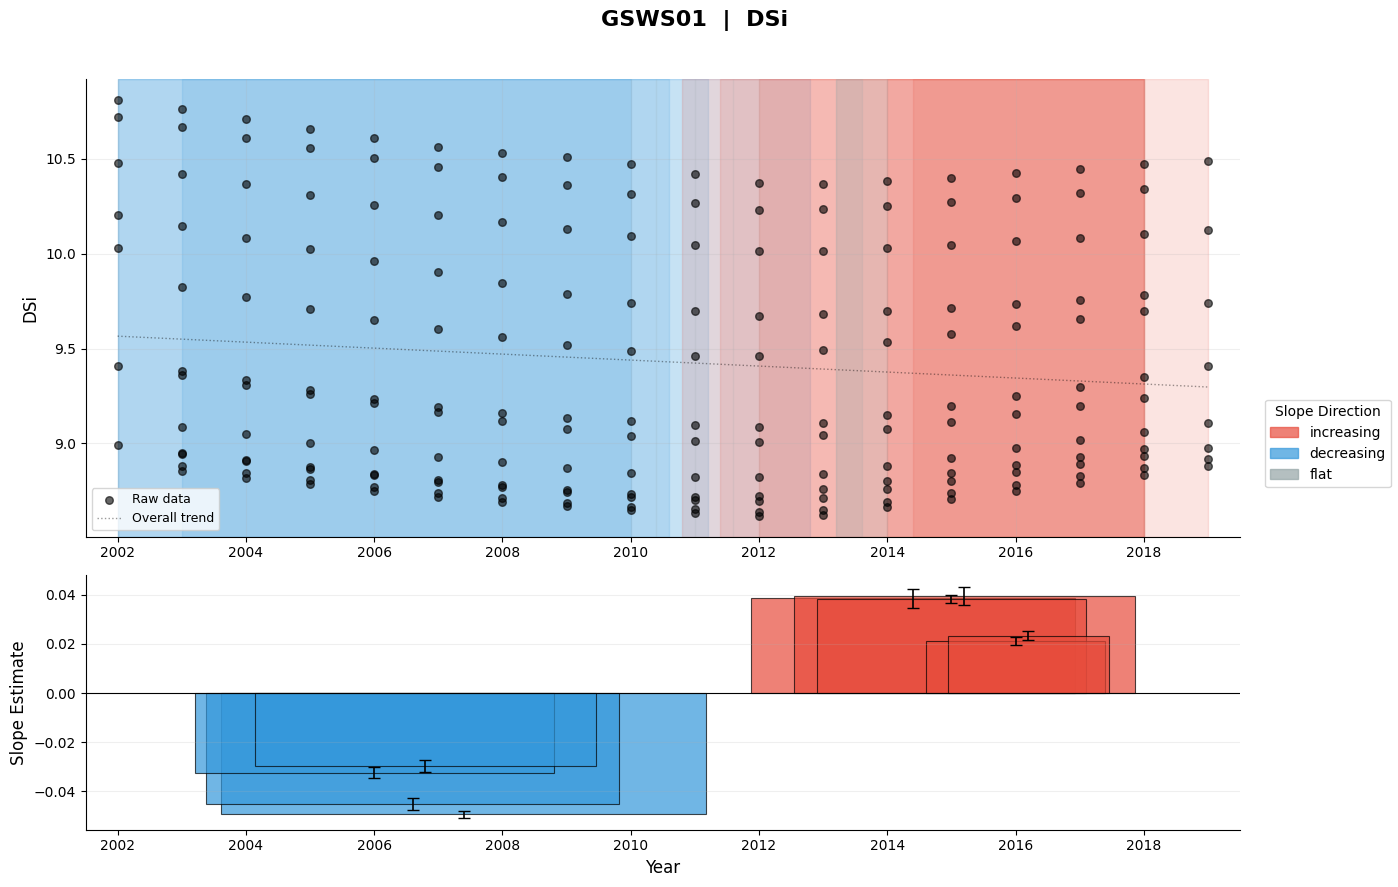

[7/28] GSWS01 - DSi:N


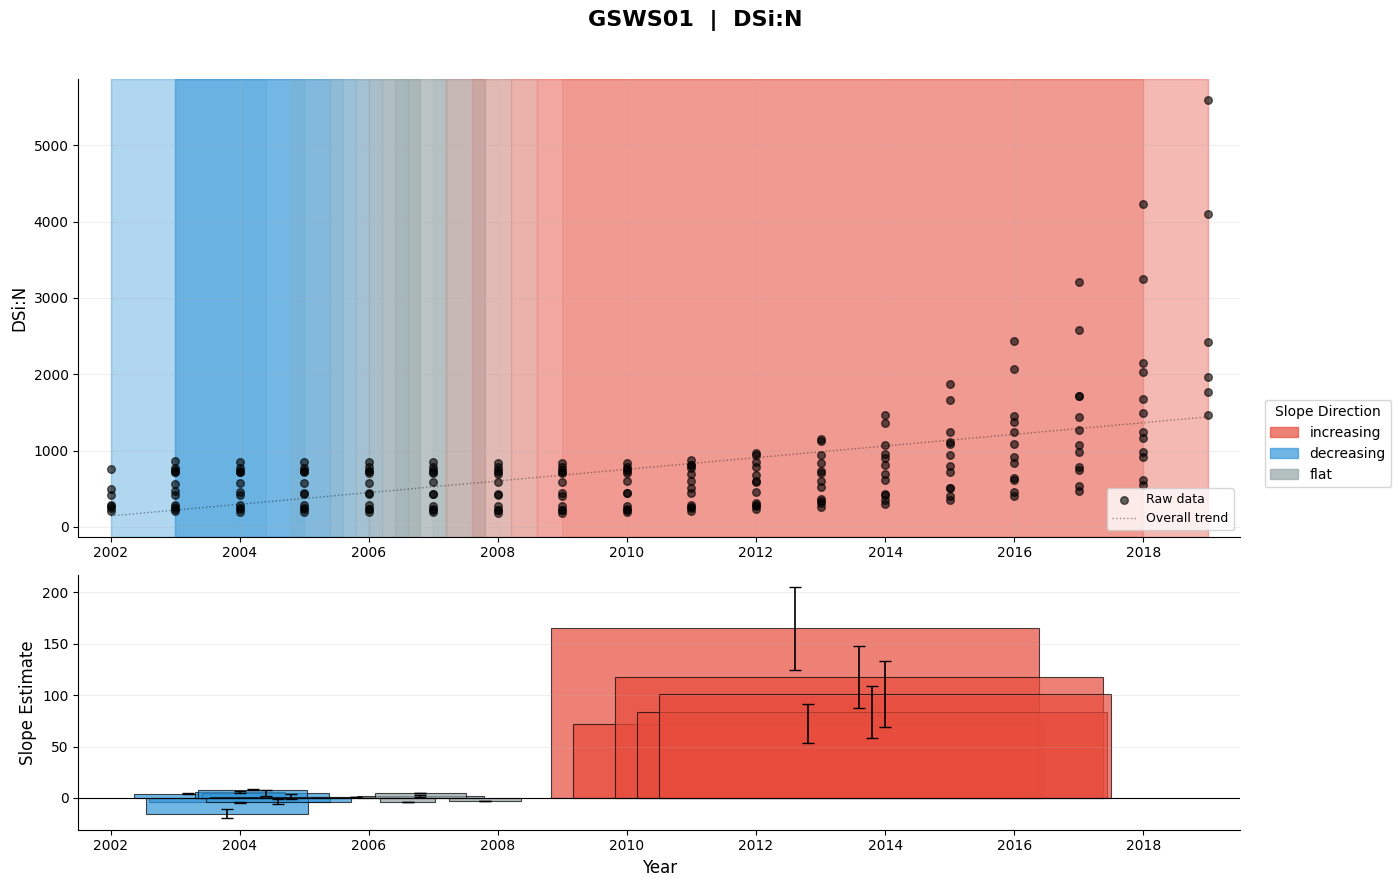

[8/28] GSWS01 - DSi:P


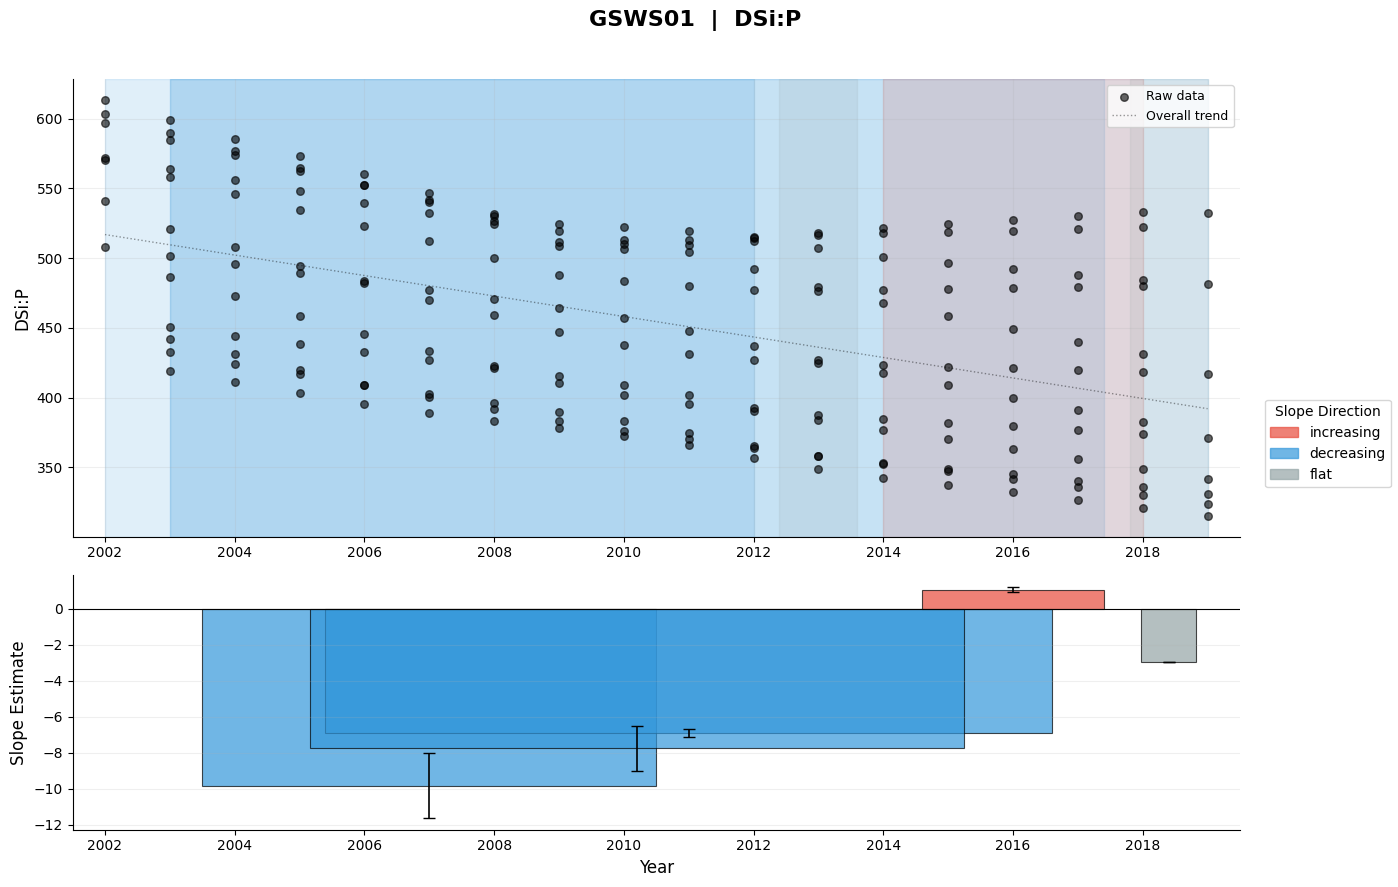

[9/28] GSWS01 - N:P


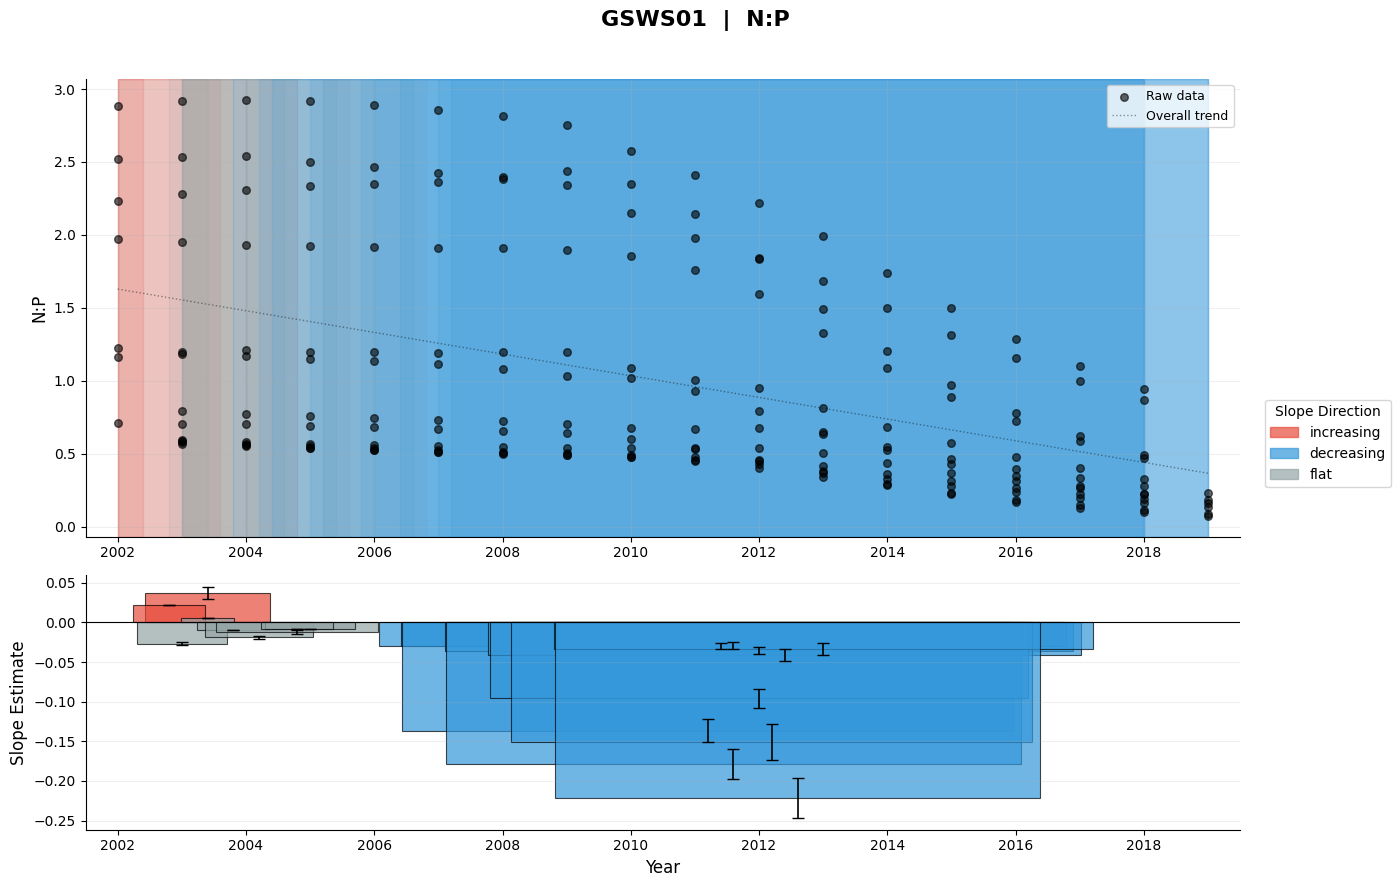

[10/28] GSWS02 - P


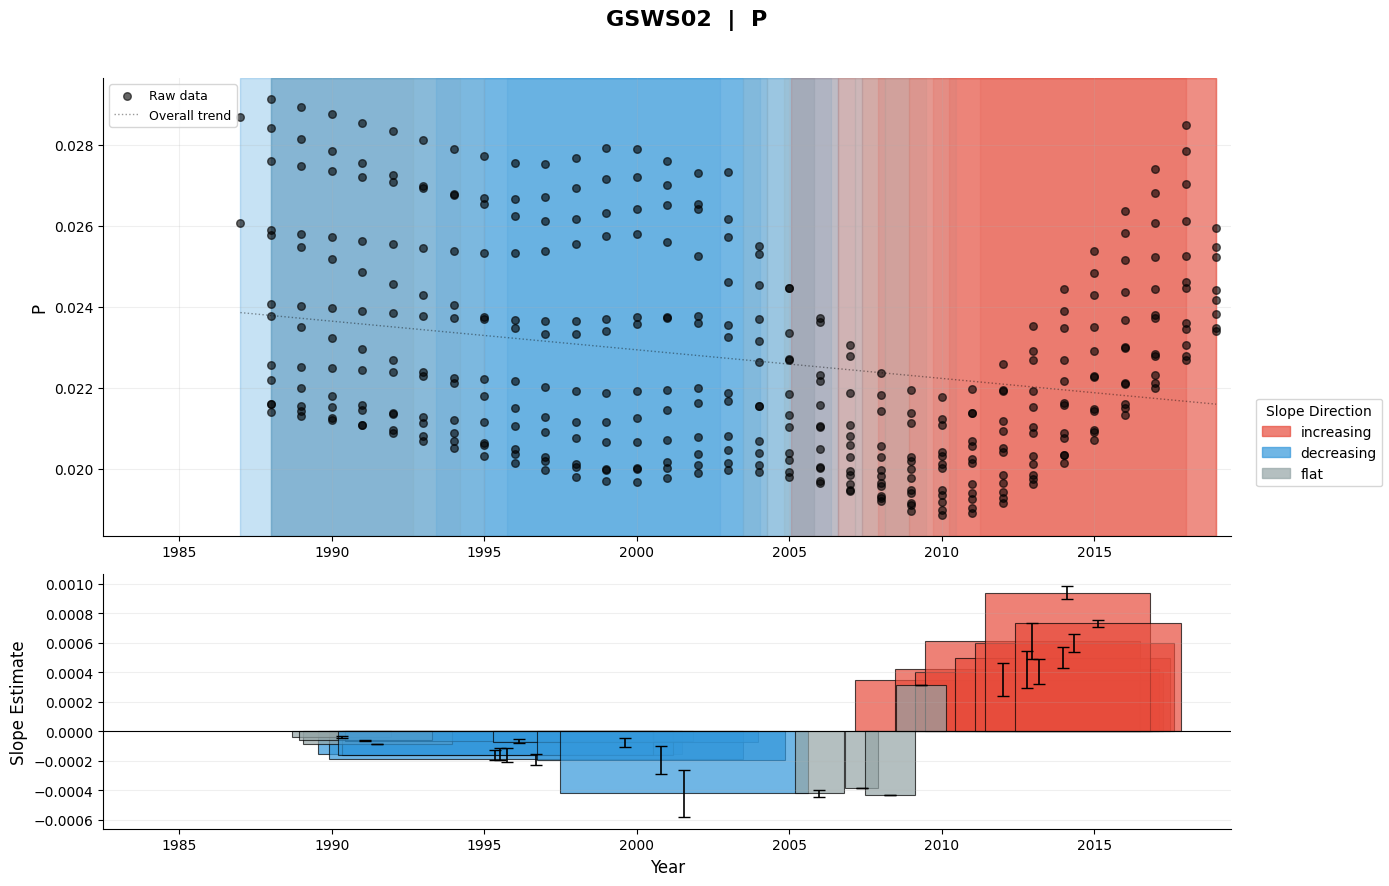

[11/28] GSWS02 - DSi


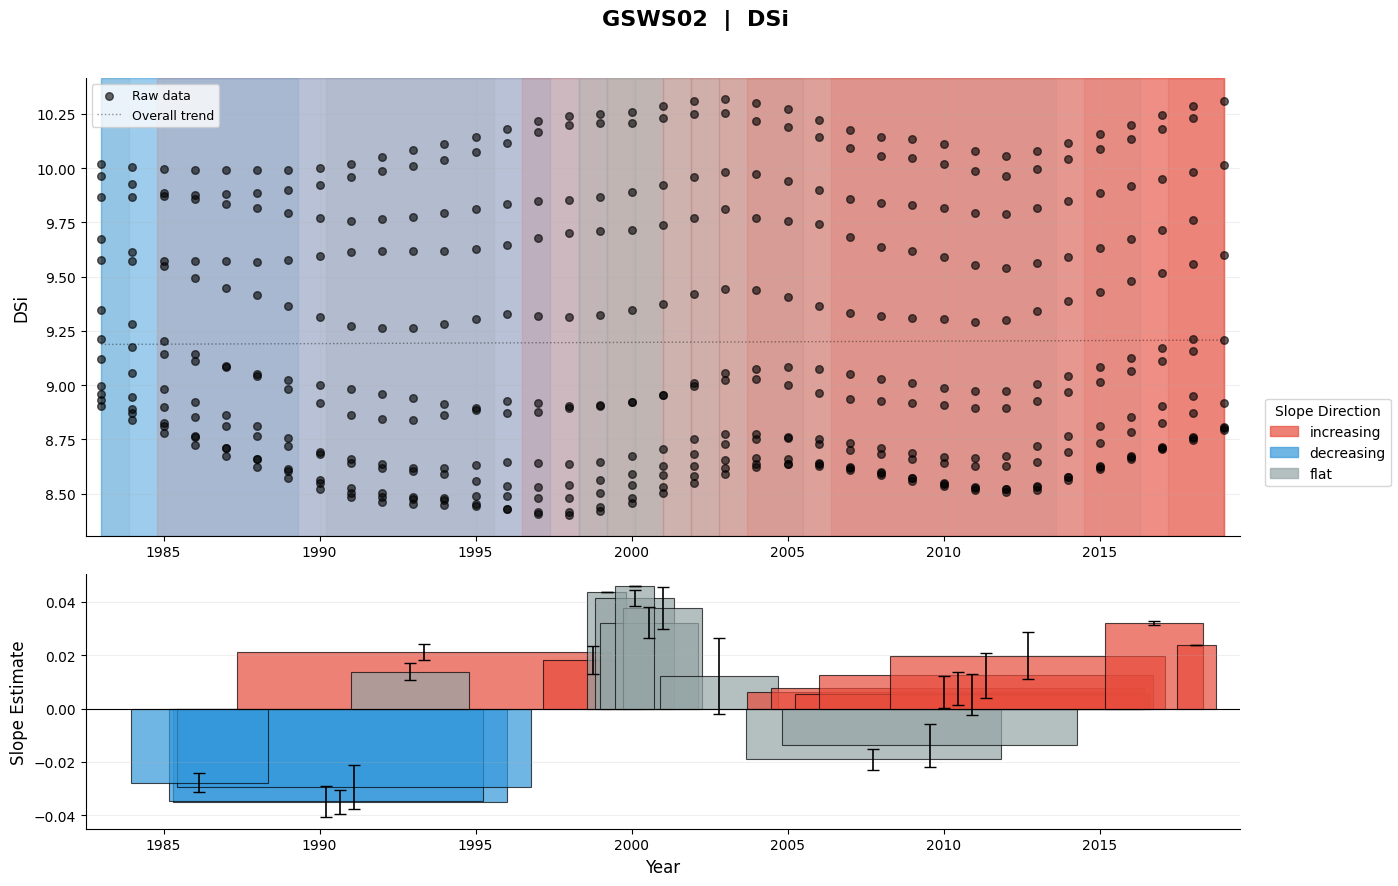

[12/28] GSWS02 - DSi:P


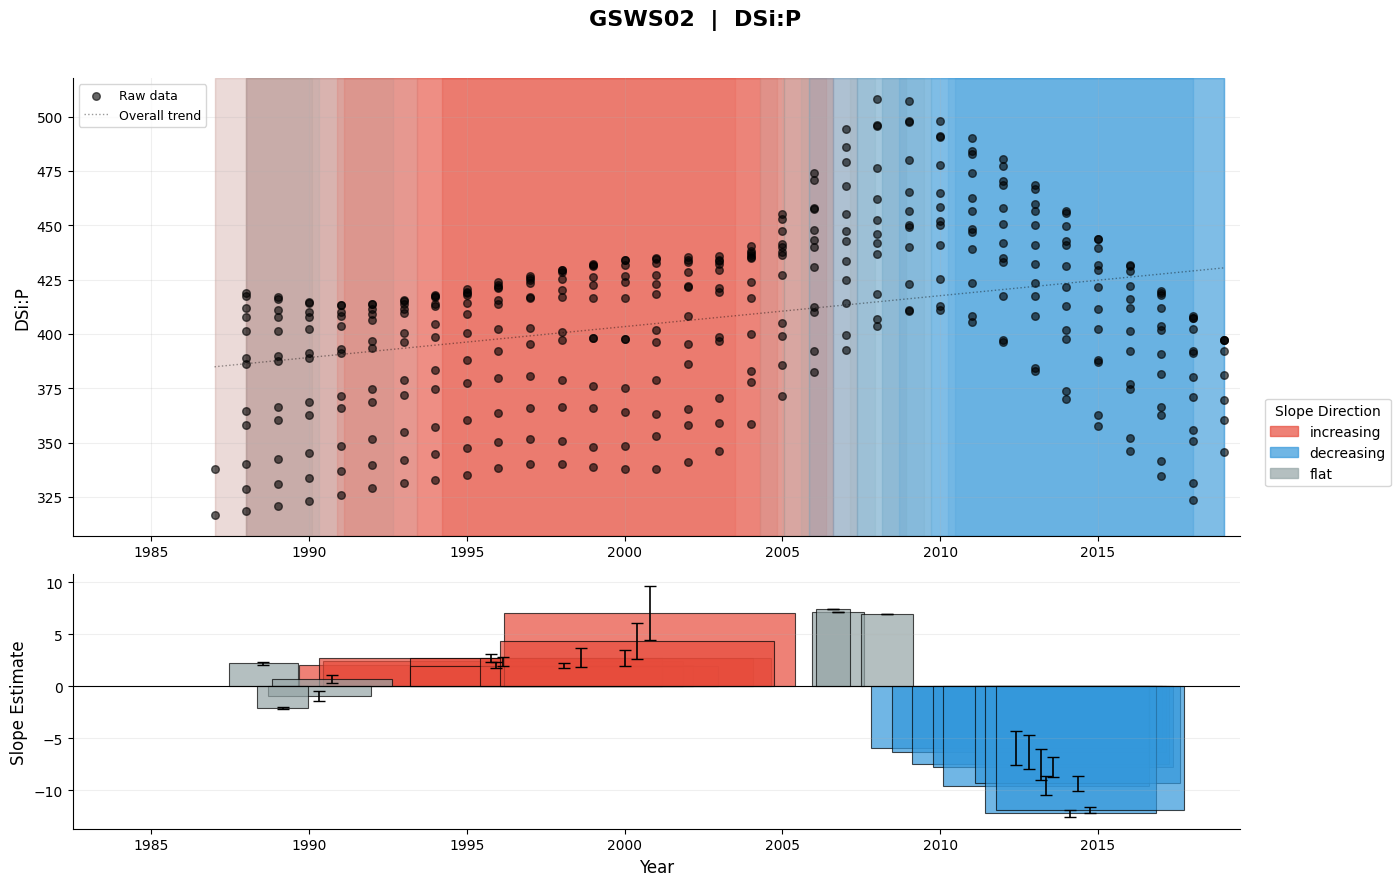

[13/28] GSWS06 - P


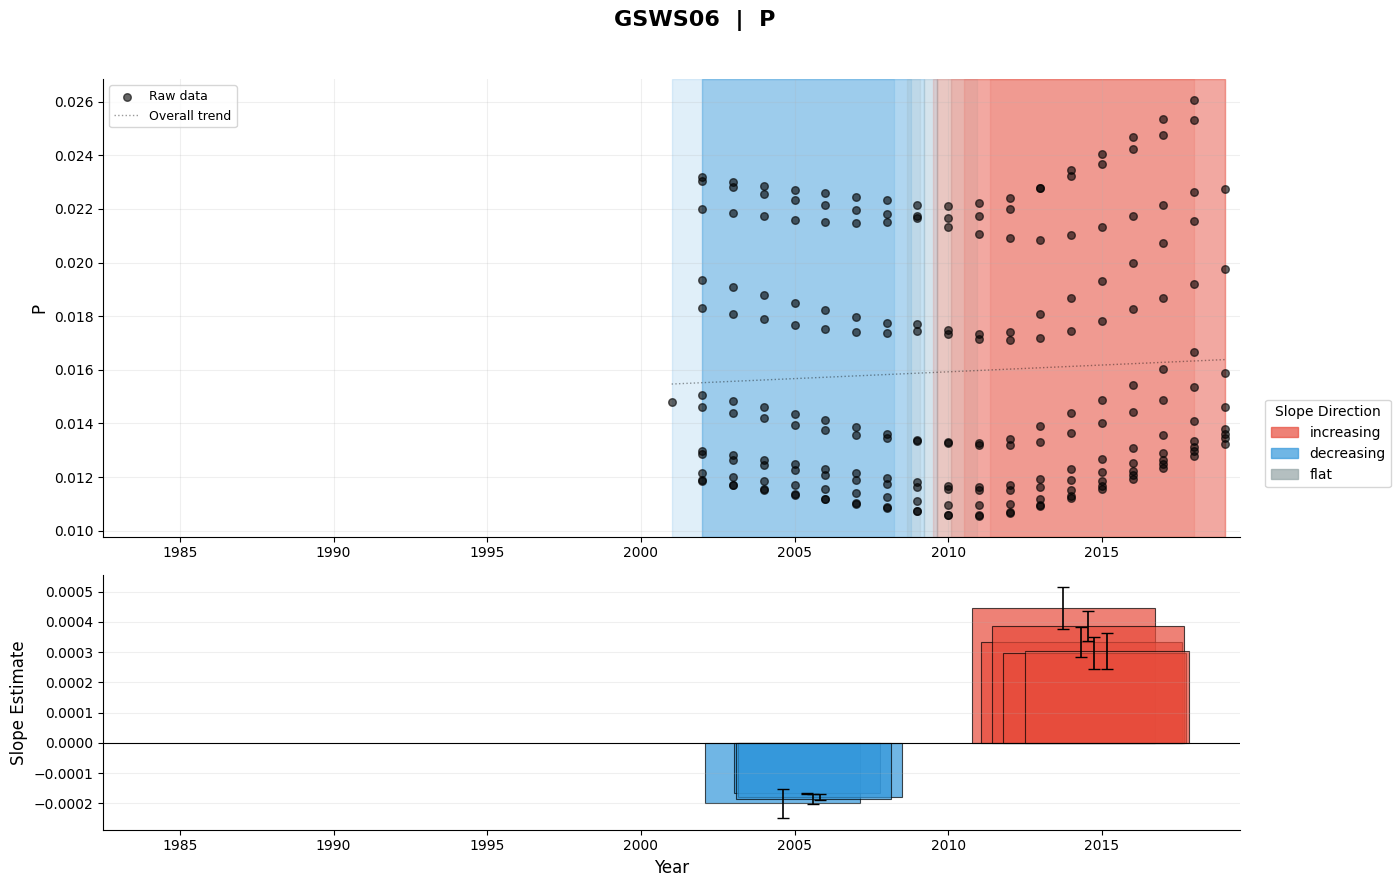

[14/28] GSWS06 - DSi


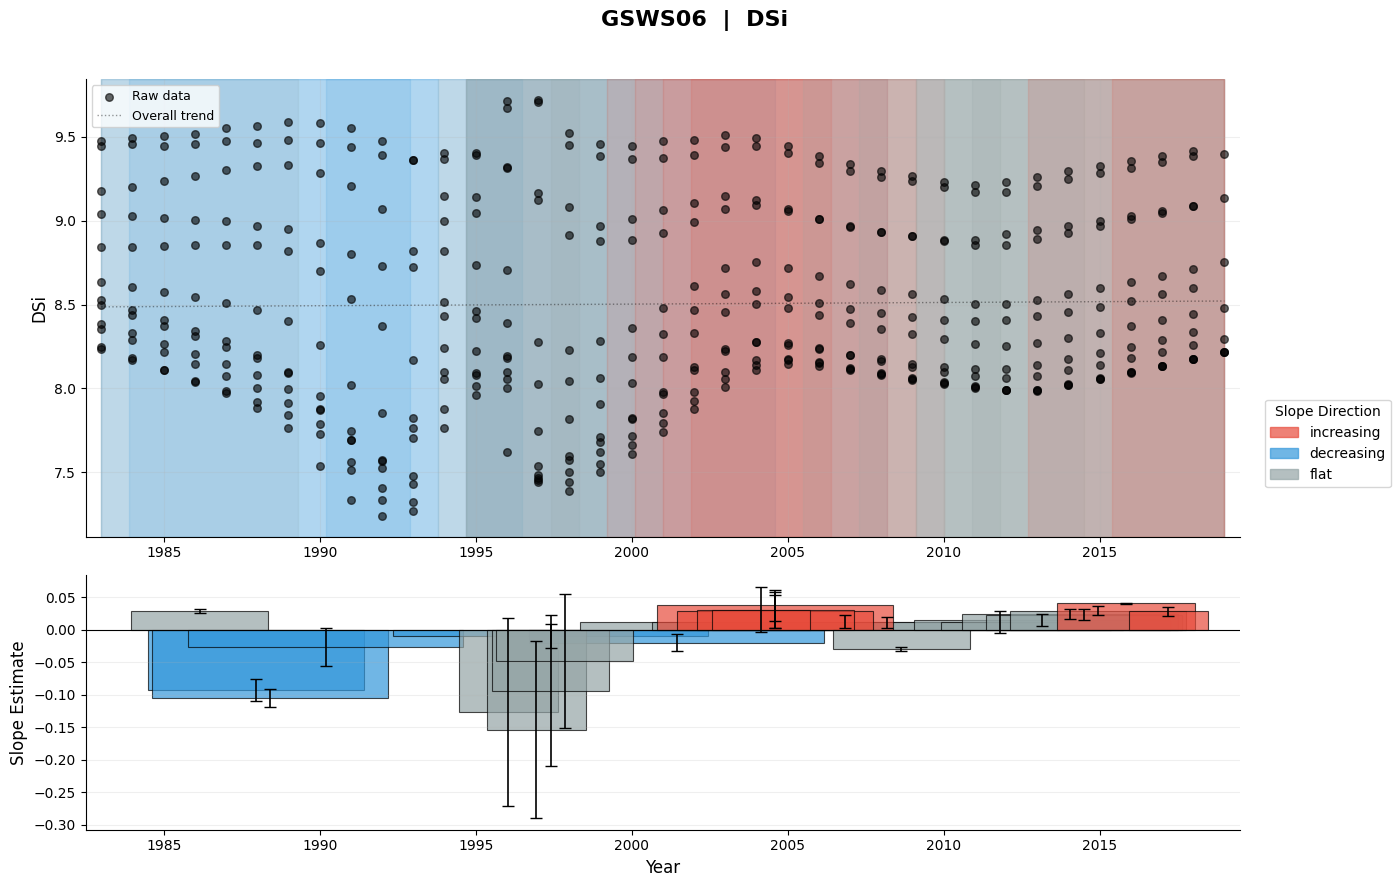

[15/28] GSWS07 - P


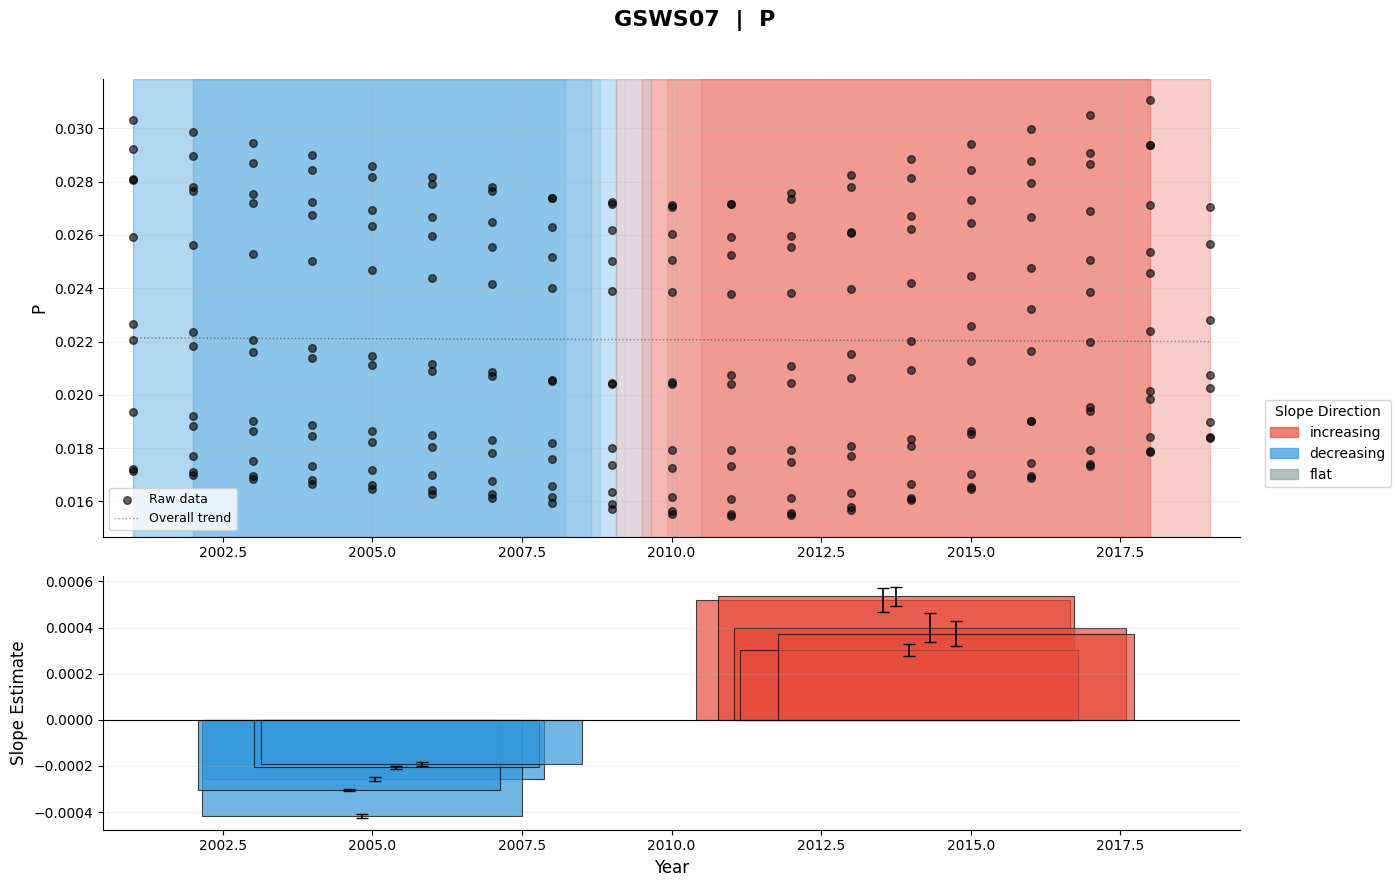

[16/28] GSWS07 - DSi


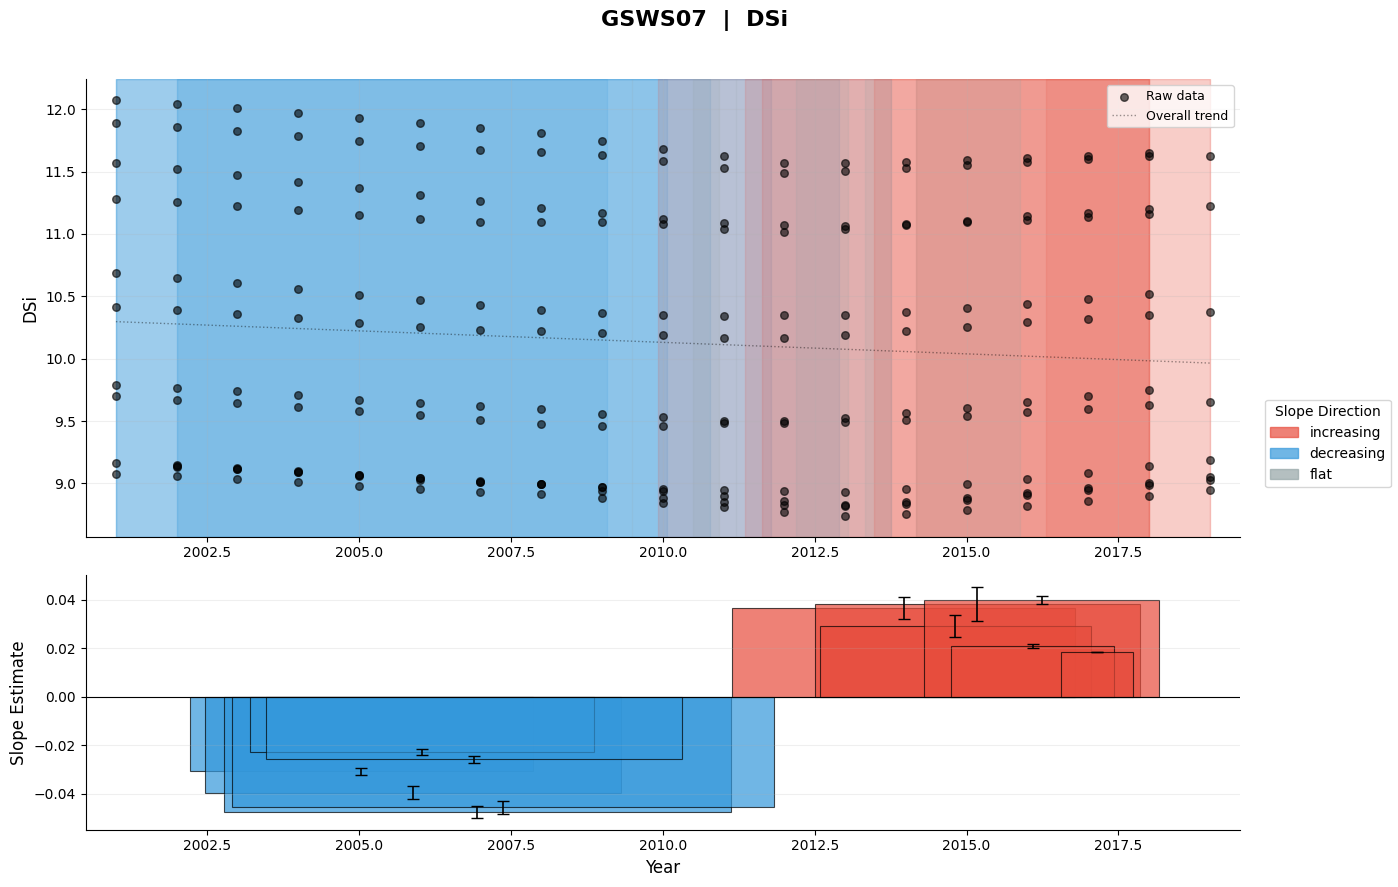

[17/28] GSWS07 - DSi:P


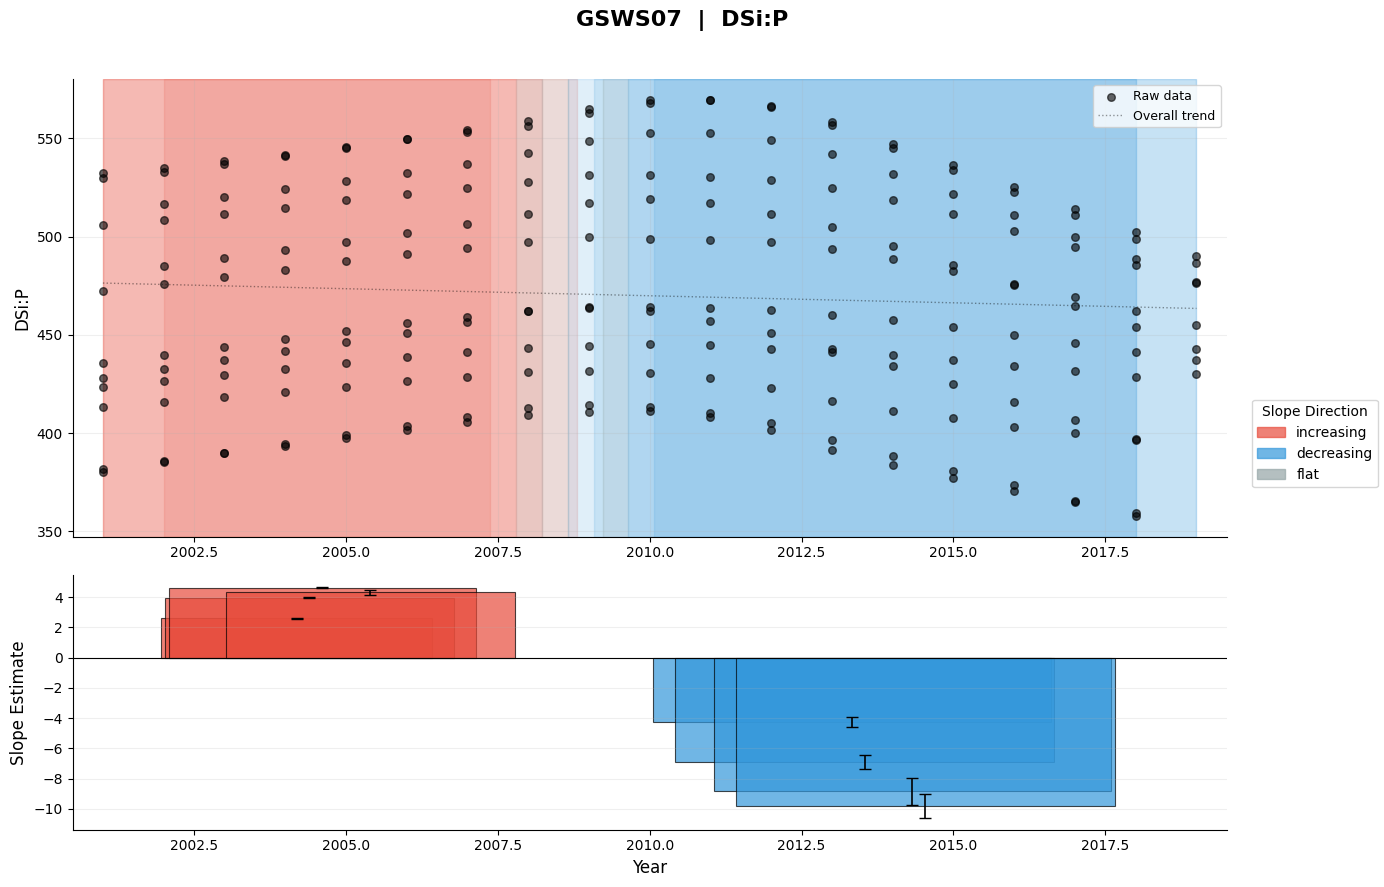

[18/28] GSWS08 - P


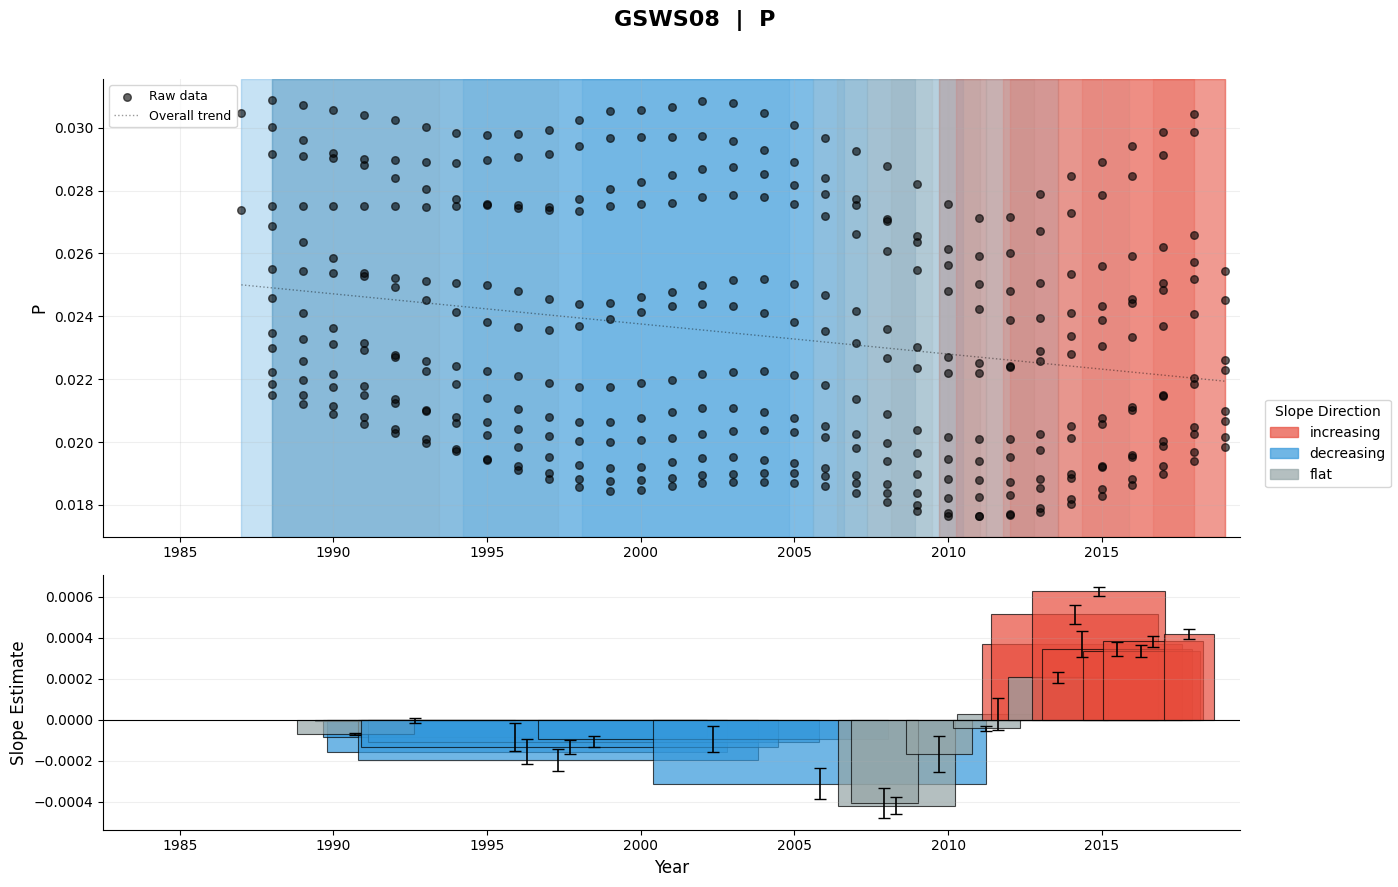

[19/28] GSWS08 - DSi


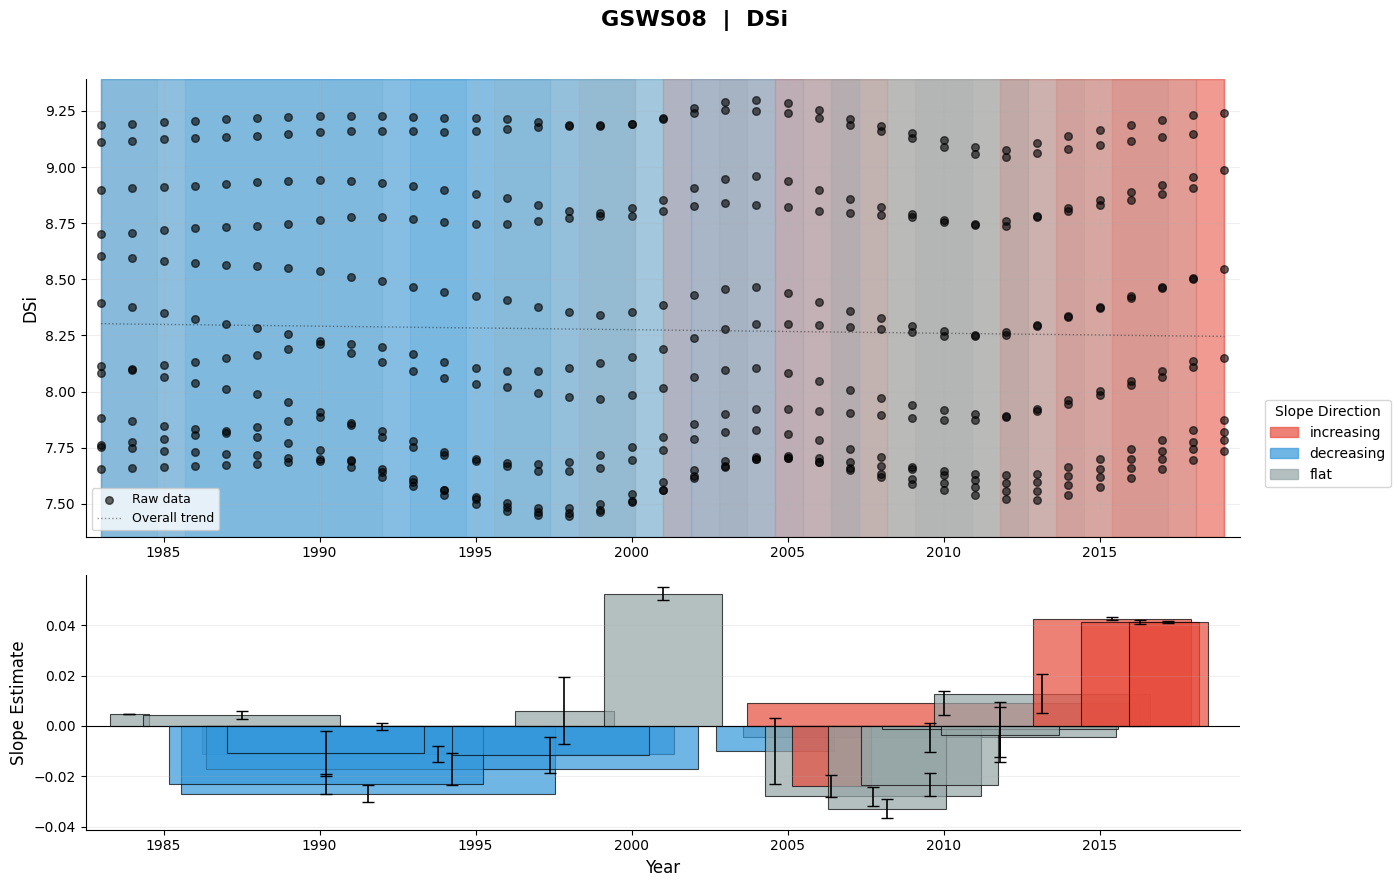

[20/28] GSWS09 - P


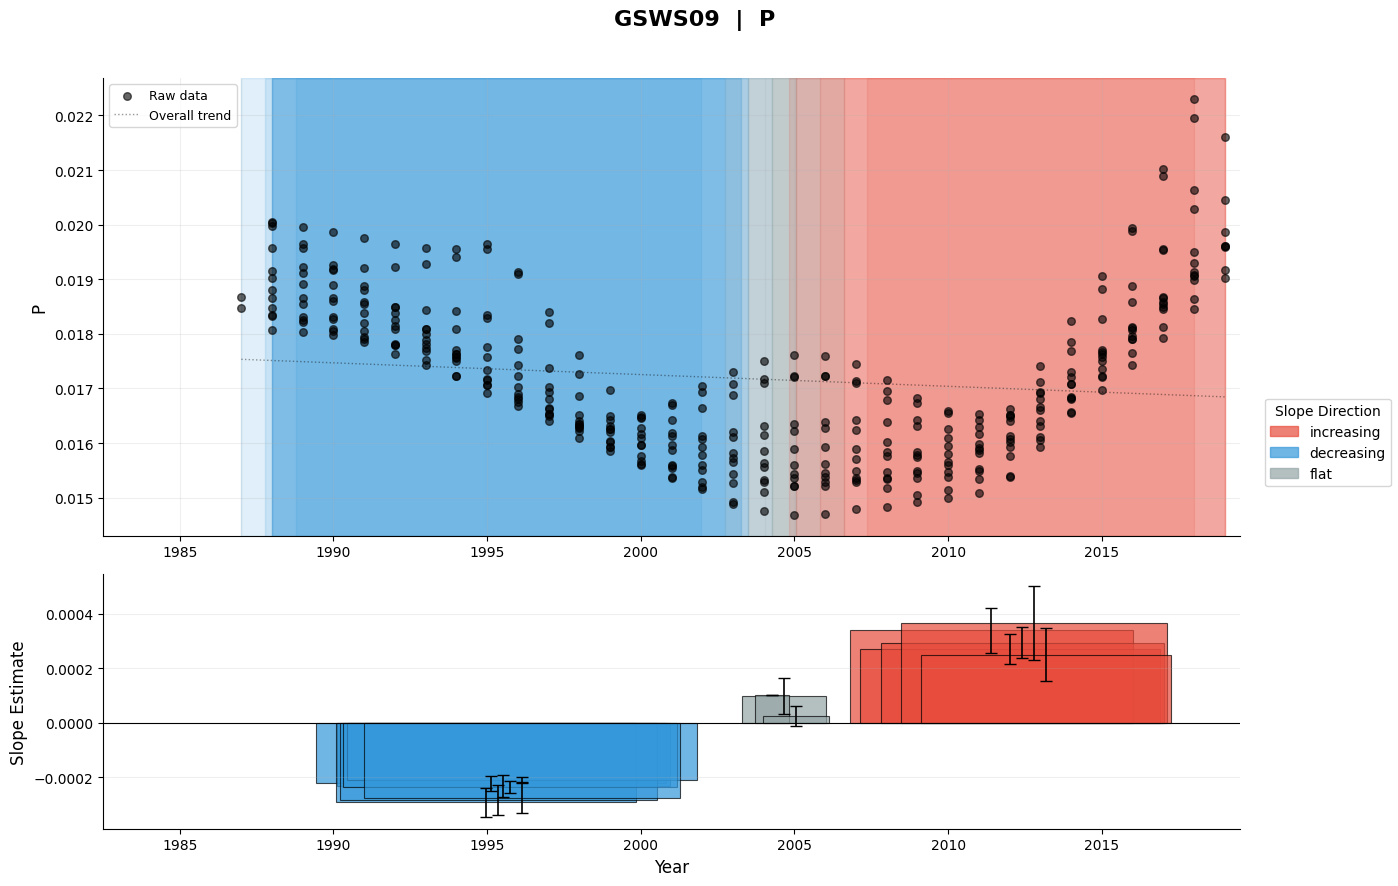

[21/28] GSWS09 - DSi


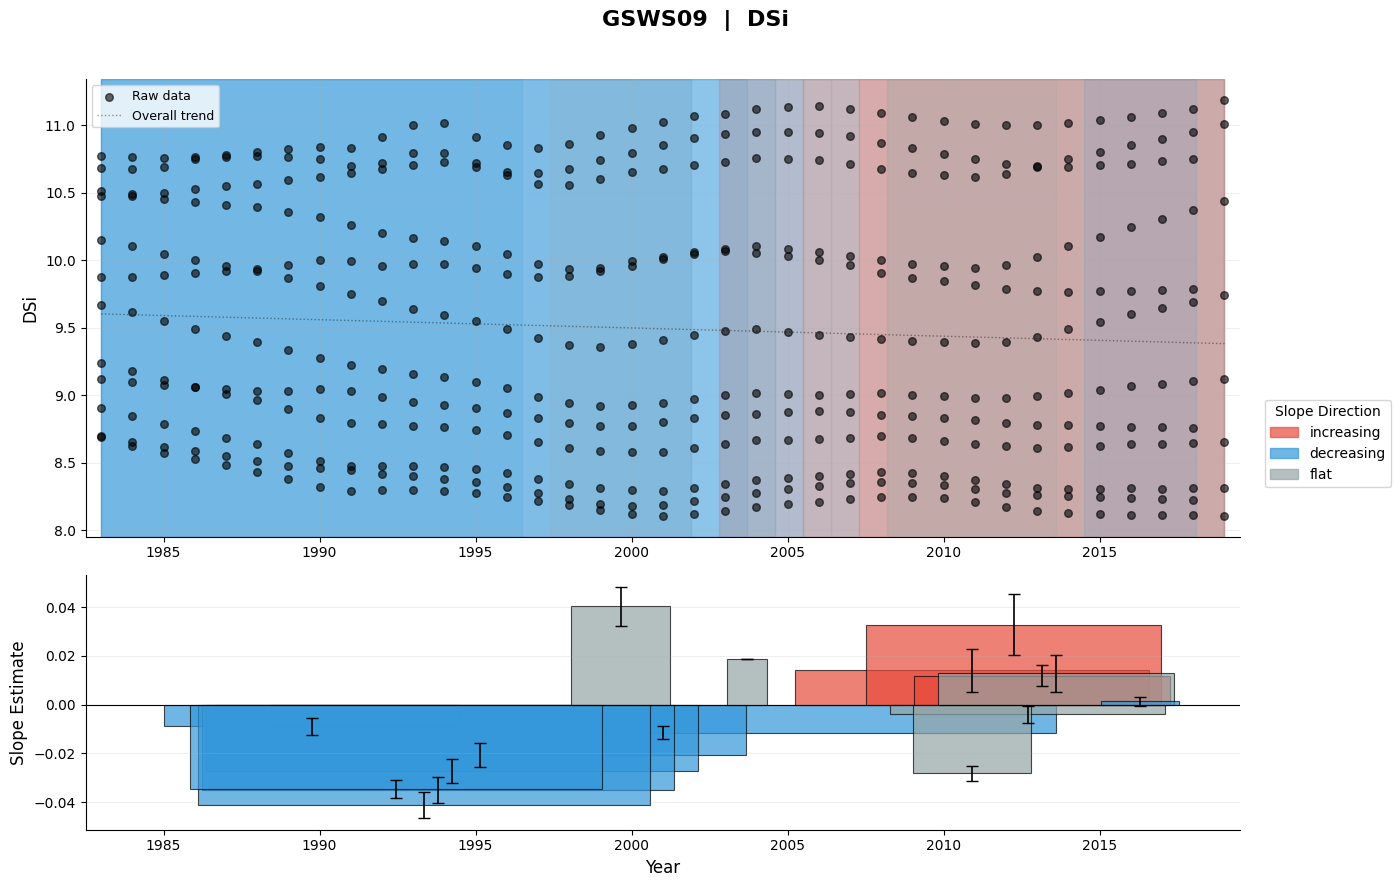

[22/28] GSWS10 - P


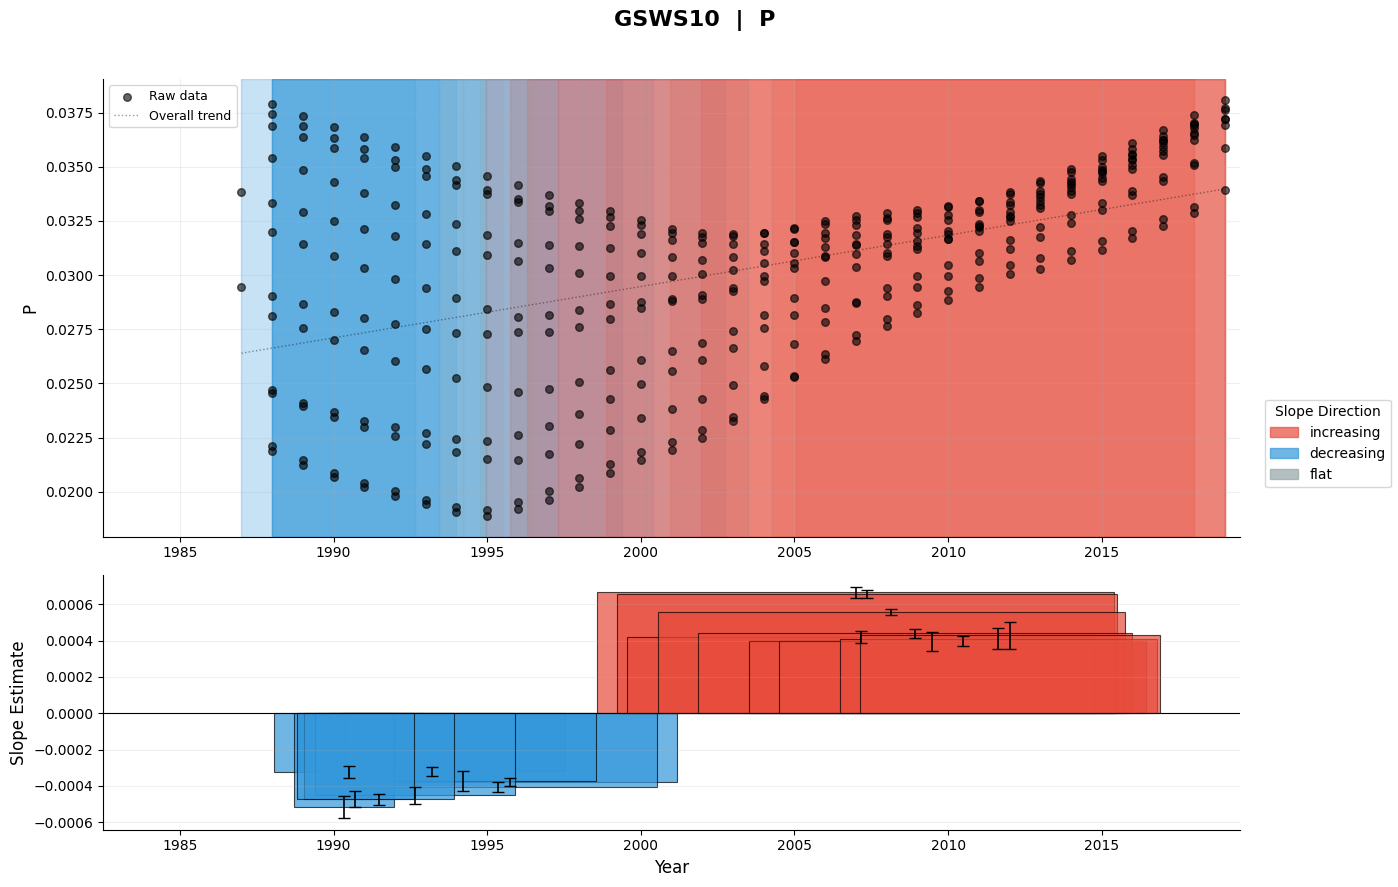

[23/28] GSWS10 - DSi


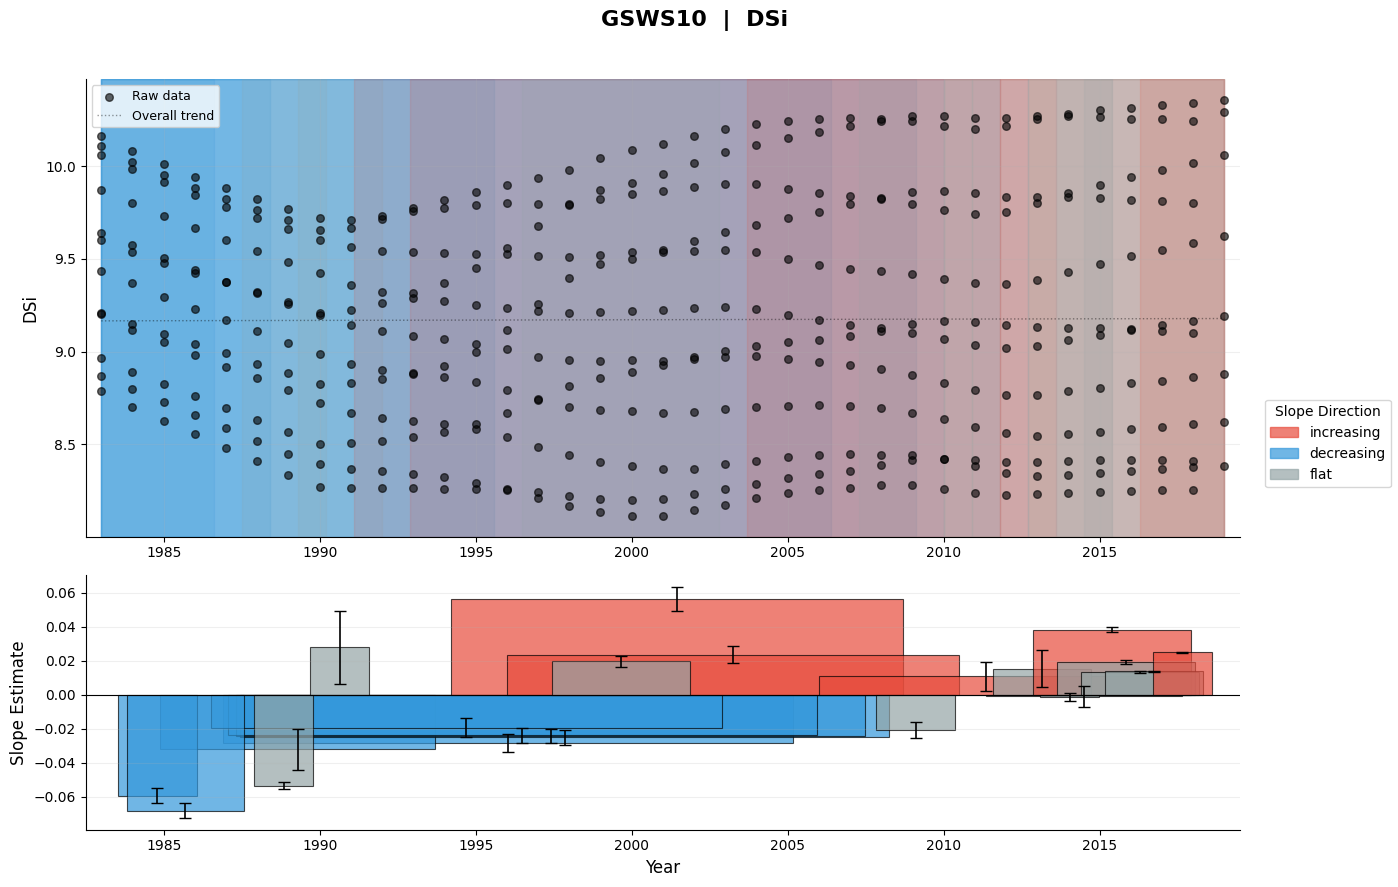

[24/28] Imnavait Weir - N


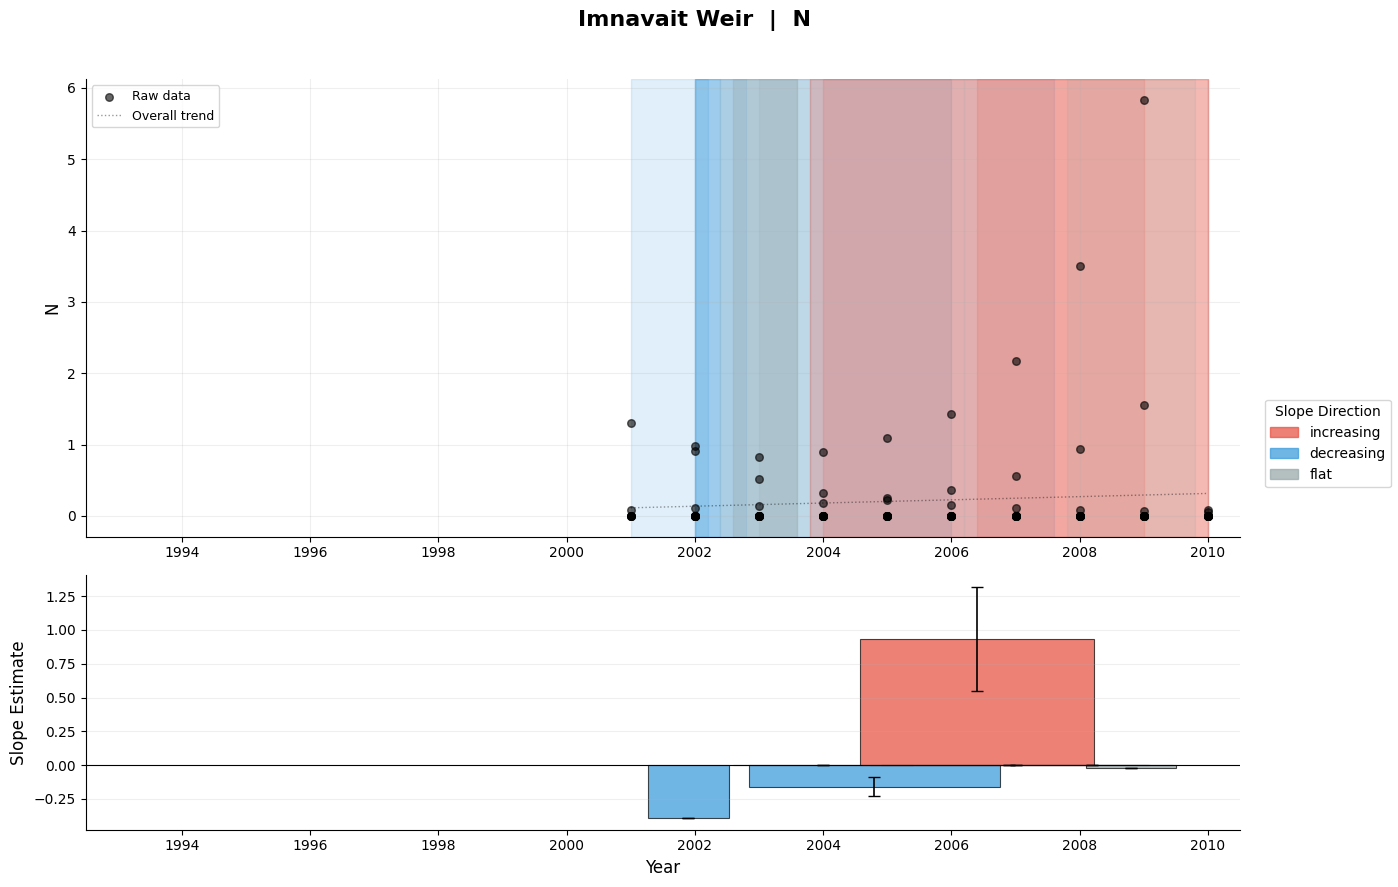

[25/28] Imnavait Weir - P


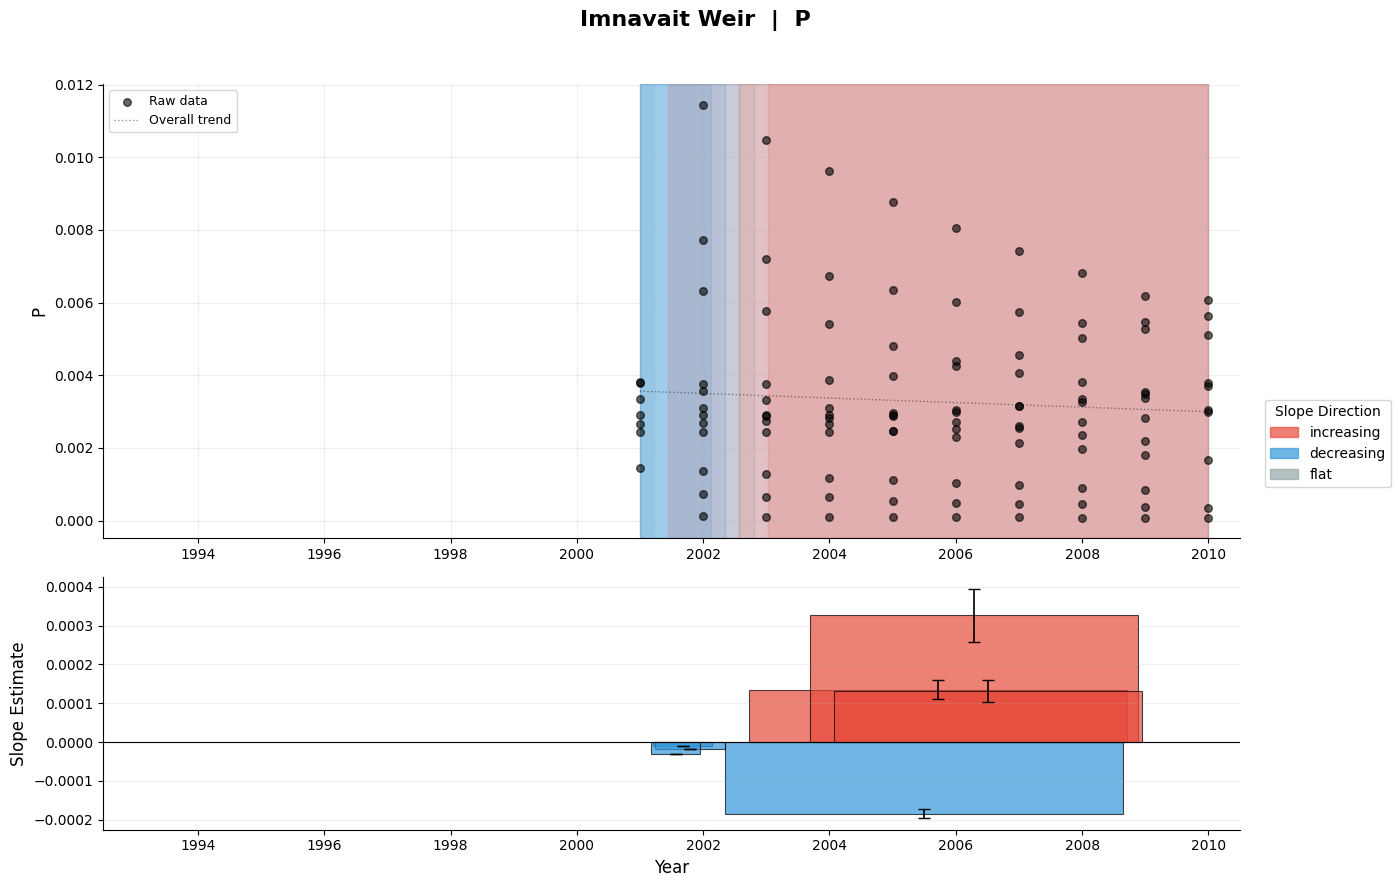

[26/28] Imnavait Weir - DSi


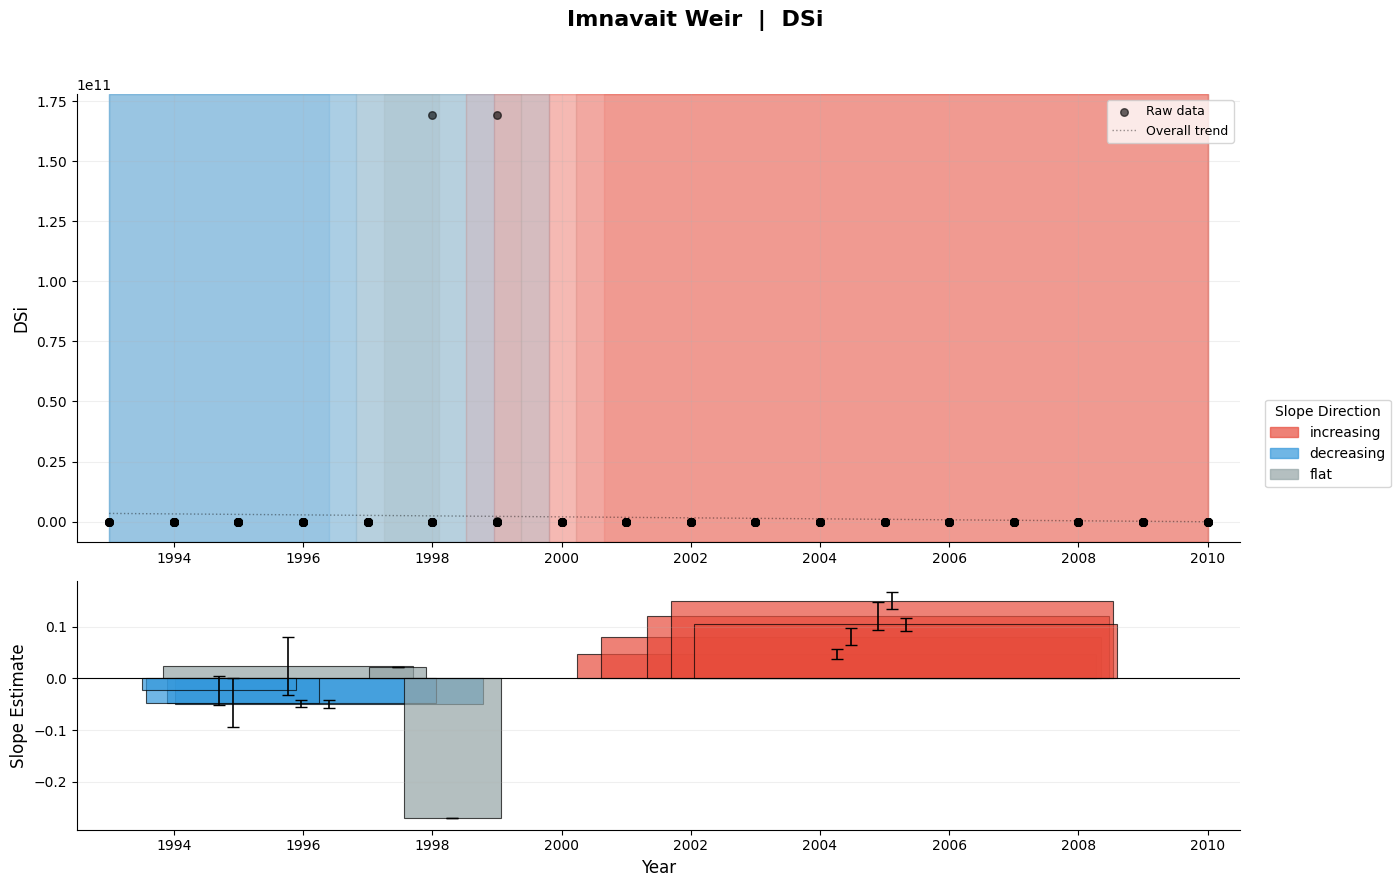

[27/28] BARWON RIVER AT DANGAR BRIDGE WALGETT - N


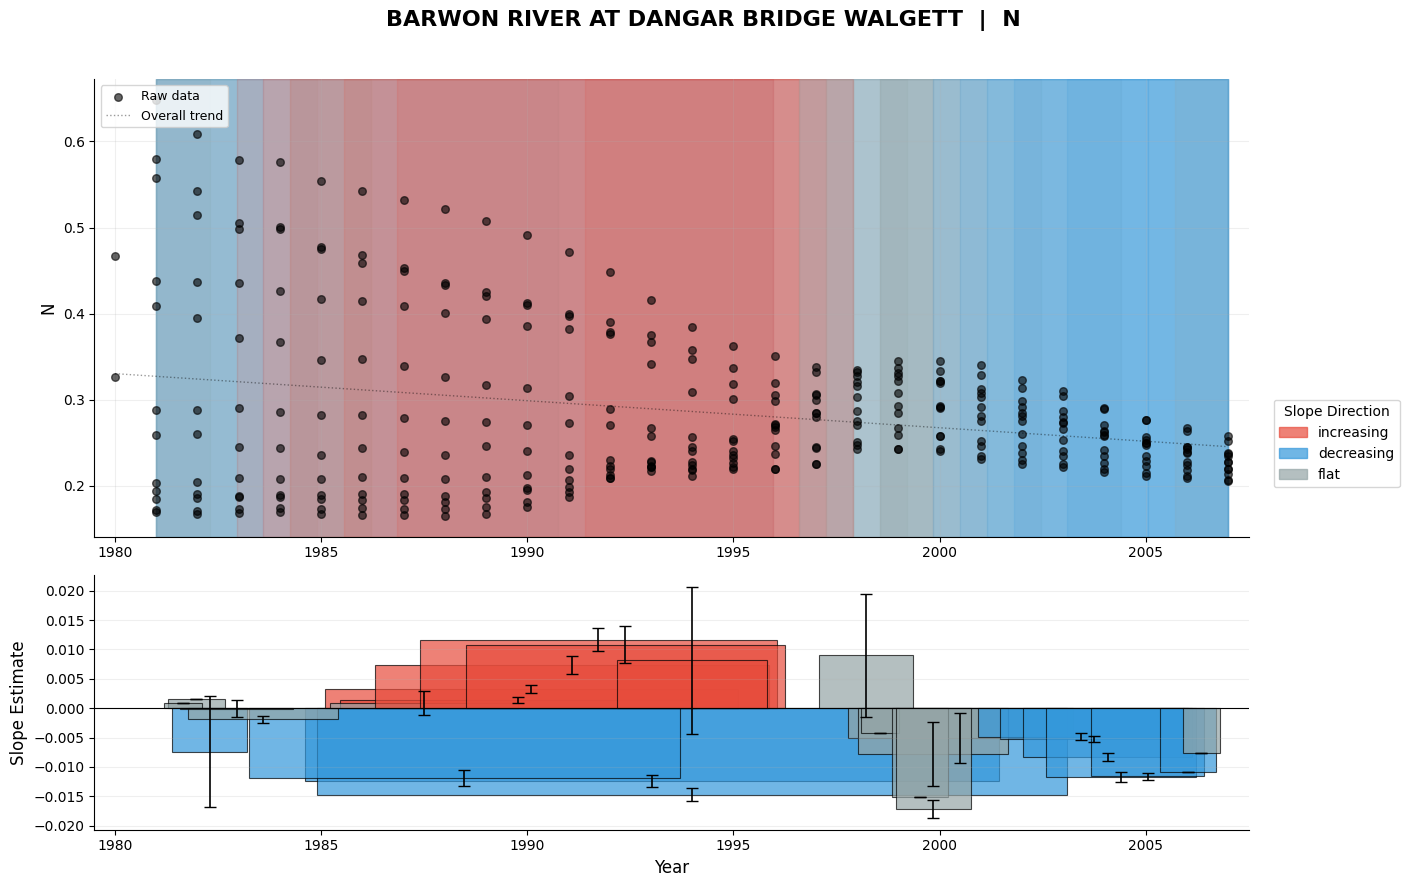

[28/28] BARWON RIVER AT DANGAR BRIDGE WALGETT - DSi


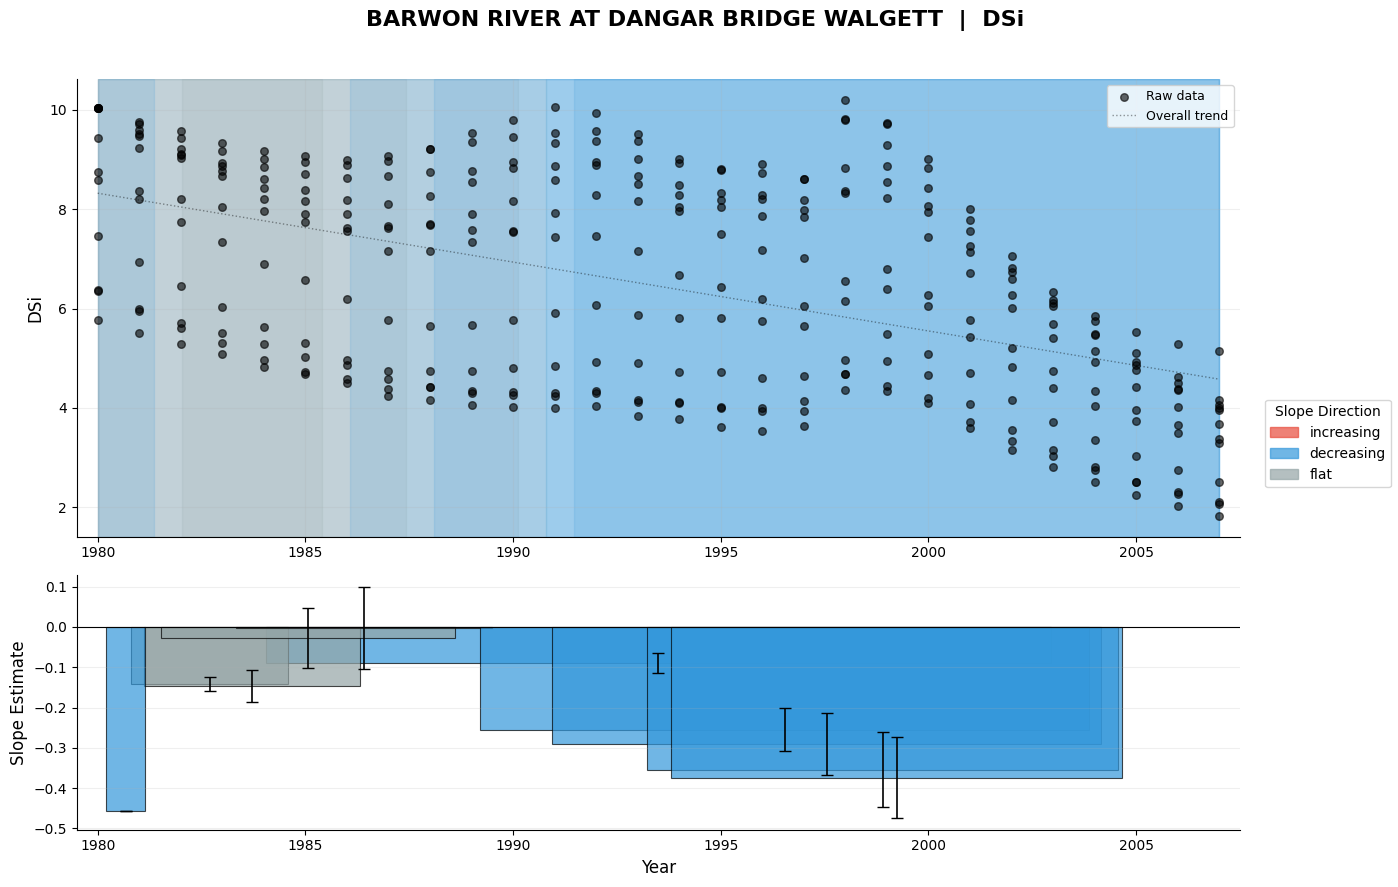


✓ All plots saved to 'sizer_plots/'


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Color map for slope directions
SLOPE_COLORS = {
    'increasing': '#e74c3c',   # Red
    'decreasing': '#3498db',   # Blue
    'flat': '#95a5a6'          # Gray
}

def plot_stream_sizer(combo_export, df_original, stream_name, chemical, 
                      output_dir='sizer_plots'):
    """
    Plot SiZer results for a single stream + chemical:
    - Top panel: raw data with colored segments by slope direction
    - Bottom panel: bar chart of slope estimates per section
    
    Parameters:
    -----------
    combo_export : pd.DataFrame
        Your combo_export dataframe
    df_original : pd.DataFrame
        Your original wide-format data (has Year, Month, stream, and chemical columns)
    stream_name : str
        Stream to plot
    chemical : str
        Chemical to plot (e.g., 'DSi', 'N', etc.)
    output_dir : str
        Where to save plots
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # --- Filter combo_export to this stream + chemical ---
    mask = (combo_export['Stream_Name'] == stream_name) & \
           (combo_export['chemical'] == chemical)
    sizer_data = combo_export[mask].copy()
    
    if len(sizer_data) == 0:
        print(f"No SiZer results for {stream_name} - {chemical}")
        return
    
    # Use the median bandwidth results only (one row per section)
    median_bw = sizer_data['sizer_bandwidth'].median()
    sizer_data = sizer_data[
        sizer_data['sizer_bandwidth'] == sizer_data['sizer_bandwidth'].unique()[
            np.argmin(np.abs(sizer_data['sizer_bandwidth'].unique() - median_bw))
        ]
    ].drop_duplicates(subset='section').copy()
    
    # Sort sections by start year
    sizer_data = sizer_data.sort_values('section_start').reset_index(drop=True)
    
    # --- Filter original data to this stream + chemical ---
    if 'stream' in df_original.columns:
        raw = df_original[df_original['stream'] == stream_name].copy()
    elif 'Stream_Name' in df_original.columns:
        raw = df_original[df_original['Stream_Name'] == stream_name].copy()
    
    raw = raw.sort_values('Year')
    
    # --- Figure ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), 
                                    gridspec_kw={'height_ratios': [1.8, 1]})
    fig.suptitle(f'{stream_name}  |  {chemical}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # ============================================================
    # TOP PANEL: Raw data + colored segments
    # ============================================================
    
    # Draw shaded background for each section
    for _, row in sizer_data.iterrows():
        ax1.axvspan(
            row['section_start'], row['section_end'],
            alpha=0.15,
            color=SLOPE_COLORS[row['sizer_slope']],
            zorder=0
        )
        
    
    # Plot raw data points
    if chemical in raw.columns:
        MONTH_MARKERS = {
        1: 'o',    # January - circle
        2: 'v',    # February - triangle down
        3: '^',    # March - triangle up
        4: '<',    # April - triangle left
        5: '>',    # May - triangle right
        6: 'D',    # June - diamond
        7: 's',    # July - square
        8: 'p',    # August - pentagon
        9: '*',    # September - star
        10: 'X',   # October - x
        11: 'P',   # November - plus
        12: 'h'    # December - hexagon
        }
        
        MONTH_NAMES = {
            1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
        }
        
        # Plot raw data with marker style by month
        if chemical in raw.columns:
            raw['Month'] = pd.to_numeric(raw['Month'], errors='coerce')
            
            for month in sorted(raw['Month'].dropna().unique()):
                month_data = raw[raw['Month'] == month]
                
                ax1.scatter(
                    month_data['Year'], 
                    month_data[chemical],
                    marker=MONTH_MARKERS.get(int(month), 'o'),
                    color='black',
                    s=40,
                    alpha=0.7,
                    zorder=2,
                    label=MONTH_NAMES.get(int(month), str(month))
                )
        
        #ax1.scatter(raw['Year'], raw[chemical], 
         #          color='black', s=30, alpha=0.6, zorder=2, label='Raw data')
        
        # Trend line through raw data
        #valid = raw[[' Year', chemical]].dropna() if ' Year' in raw.columns else raw[['Year', chemical]].dropna()
        #if len(valid) > 1:
         #   z = np.polyfit(valid['Year'], valid[chemical], 1)
          #  p = np.poly1d(z)
           # x_line = np.linspace(valid['Year'].min(), valid['Year'].max(), 100)
            #ax1.plot(x_line, p(x_line), color='black', linestyle=':', 
             #       linewidth=1, alpha=0.4, label='Overall trend')
    
    ax1.set_ylabel(chemical, fontsize=12)
    ax1.set_xlabel('')
    ax1.grid(True, alpha=0.2)
    ax1.legend(loc='best', fontsize=9)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1_handles, ax1_labels = ax1.get_legend_handles_labels()
    ax1.legend(ax1_handles, ax1_labels,
               loc='best', fontsize=7, frameon=True,
               title='Month', title_fontsize=8,
               ncol=2)
    # ============================================================
    # BOTTOM PANEL: Slope estimates per section
    # ============================================================
    
    # x-positions for bars = midpoint of each section
    mid_years = (sizer_data['section_start'] + sizer_data['section_end']) / 2
    bar_widths = (sizer_data['section_end'] - sizer_data['section_start']) * 0.7
    
    bars = ax2.bar(
        mid_years, 
        sizer_data['slope_estimate'],
        width=bar_widths,
        color=[SLOPE_COLORS[s] for s in sizer_data['sizer_slope']],
        alpha=0.7,
        edgecolor='black',
        linewidth=0.8
    )
    
    # Error bars from slope_std_error
    ax2.errorbar(
        mid_years, 
        sizer_data['slope_estimate'],
        yerr=1.96 * sizer_data['slope_std_error'],  # 95% CI
        fmt='none', 
        color='black', 
        capsize=4, 
        linewidth=1.2
    )
    
    # Horizontal zero line
    ax2.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
    
    ax2.set_ylabel('Slope Estimate', fontsize=12)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.grid(True, alpha=0.2, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Align x-axes
    all_years = list(sizer_data['section_start']) + list(sizer_data['section_end'])
    if chemical in raw.columns:
        all_years += list(raw['Year'].dropna())
    x_min, x_max = min(all_years) - 0.5, max(all_years) + 0.5
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    
    # --- Legend (shared) ---
    legend_patches = [mpatches.Patch(color=v, alpha=0.7, label=k) 
                      for k, v in SLOPE_COLORS.items()]
    fig.legend(handles=legend_patches, loc='center right', 
               fontsize=10, frameon=True, title='Slope Direction')
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    
    # Save
    safe_name = stream_name.replace('/', '_').replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{safe_name}_{chemical}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_all_streams_sizer(combo_export, df_original, output_dir='sizer_plots'):
    """
    Loop over all unique stream + chemical combinations and plot each one.
    """
    # Get unique stream-chemical pairs
    pairs = combo_export[['Stream_Name', 'chemical']].drop_duplicates()
    
    print(f"Plotting {len(pairs)} stream-chemical combinations...")
    
    for i, (_, row) in enumerate(pairs.iterrows(), 1):
        print(f"[{i}/{len(pairs)}] {row['Stream_Name']} - {row['chemical']}")
        plot_stream_sizer(
            combo_export, 
            df_original, 
            stream_name=row['Stream_Name'],
            chemical=row['chemical'],
            output_dir=output_dir
        )
    
    print(f"\n✓ All plots saved to '{output_dir}/'")


# ============================================================
# USAGE
# ============================================================

# Plot a single stream + chemical
plot_stream_sizer(
    combo_export=combo_export,
    df_original=wrtds_focal,       # your original wide-format df
    stream_name='GSMACK',
    chemical='N'
)

# Plot all streams
plot_all_streams_sizer(
    combo_export=combo_export,
    df_original=wrtds_focal
)    

In [14]:
print(combo_export.columns)

Index(['sizer_bandwidth', 'section', 'section_start', 'section_end',
       'section_duration', 'sizer_slope', 'LTER', 'Stream_Name', 'drainSqKm',
       'chemical', 'Month', 'season', 'F_statistic', 'test_p_value',
       'r_squared', 'adj_r_squared', 'sigma', 'df', 'df_residual', 'nobs',
       'logLik', 'AIC', 'BIC', 'deviance', 'slope_estimate', 'slope_std_error',
       'LTER_stream', 'mean_response', 'sd_response', 'percent_change'],
      dtype='object')


In [ ]:
def plot_sizer_slopes_by_month(combo_export, df_original, stream_name, chemical,
                               output_dir='sizer_plots'):
    """
    12-panel plot of slope estimates per section, one panel per month.
    
    Parameters:
    -----------
    combo_export : pd.DataFrame
        Your combo_export dataframe
    df_original : pd.DataFrame
        Original wide-format data
    stream_name : str
        Stream to plot
    chemical : str
        Chemical to plot
    output_dir : str
        Where to save
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    MONTH_NAMES = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    
    SLOPE_COLORS = {
        'increasing': '#e74c3c',
        'decreasing': '#3498db',
        'flat': '#95a5a6'
    }
    
    # --- Filter combo_export to this stream + chemical ---
    mask = (combo_export['Stream_Name'] == stream_name) & \
           (combo_export['chemical'] == chemical)
    sizer_data = combo_export[mask].copy()
    
    if len(sizer_data) == 0:
        print(f"No SiZer results for {stream_name} - {chemical}")
        return
    
    # Use median bandwidth, one row per section per month
    median_bw = sizer_data['sizer_bandwidth'].median()
    sizer_data = sizer_data[
        sizer_data['sizer_bandwidth'] == sizer_data['sizer_bandwidth'].unique()[
            np.argmin(np.abs(sizer_data['sizer_bandwidth'].unique() - median_bw))
        ]
    ].copy()
    
    # Ensure Month is numeric
    sizer_data['Month'] = pd.to_numeric(sizer_data['Month'], errors='coerce')
    
    # Global x-axis range across all months
    x_min = sizer_data['section_start'].min() - 0.5
    x_max = sizer_data['section_end'].max() + 0.5
    
    # Global y-axis range (so all panels are comparable)
    y_min = sizer_data['slope_estimate'].min()
    y_max = sizer_data['slope_estimate'].max()
    y_err = (1.96 * sizer_data['slope_std_error'])
    y_min = min(y_min, (sizer_data['slope_estimate'] - y_err).min())
    y_max = max(y_max, (sizer_data['slope_estimate'] + y_err).max())
    y_pad = (y_max - y_min) * 0.15
    y_min -= y_pad
    y_max += y_pad
    
    # --- Figure: 4 rows x 3 cols ---
    fig, axes = plt.subplots(12, 1, figsize=(7, 7),
                             sharex=True, sharey=True)
    fig.suptitle(f'{stream_name}  |  {chemical}  |  Slope by Month',
                 fontsize=16, fontweight='bold', y=0.98)
    
    axes_flat = axes.flatten()
    
    for i, month in enumerate(range(1, 13)):
        ax = axes_flat[i]
        
        # Filter to this month
        month_data = sizer_data[sizer_data['Month'] == month].copy()
        month_data = month_data.drop_duplicates(subset='section').sort_values('section_start')
        
        # Month label
        ax.set_title(MONTH_NAMES[month], fontsize=11, fontweight='bold', pad=4)
        
        if len(month_data) == 0:
            # No data - gray out the panel
            ax.set_facecolor('#f0f0f0')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center',
                    fontsize=9, color='gray', transform=ax.transAxes)
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            continue
        
        # Bar midpoints and widths
        mid_years = (month_data['section_start'] + month_data['section_end']) / 2
        bar_widths = (month_data['section_end'] - month_data['section_start']) * 0.7
        
        # Bars
        ax.bar(
            mid_years,
            month_data['slope_estimate'],
            width=bar_widths,
            color=[SLOPE_COLORS[s] for s in month_data['sizer_slope']],
            alpha=0.7,
            edgecolor='black',
            linewidth=0.6
        )
        
        # Error bars
        ax.errorbar(
            mid_years,
            month_data['slope_estimate'],
            yerr=1.96 * month_data['slope_std_error'],
            fmt='none',
            color='black',
            capsize=3,
            linewidth=1
        )
        
        # Zero line
        ax.axhline(y=0, color='black', linewidth=0.8)
        
        # Grid
        ax.grid(True, alpha=0.2, axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set shared limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    
    # Shared axis labels
    #for ax in axes[-1]:  # Bottom row gets x label
        ax.set_xlabel('Year', fontsize=10)
    #for ax in axes[0]:   # Left column gets y label
        ax.set_ylabel('Slope', fontsize=10)
    
    # Shared legend at bottom
    legend_patches = [mpatches.Patch(color=v, alpha=0.7, label=k)
                      for k, v in SLOPE_COLORS.items()]
    fig.legend(handles=legend_patches, loc='lower center',
               ncol=3, fontsize=10, frameon=True,
               title='Slope Direction', title_fontsize=11,
               bbox_to_anchor=(0.5, 0.01))
    
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    
    # Save
    safe_name = stream_name.replace('/', '_').replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{safe_name}_{chemical}_monthly_slopes.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# ============================================================
# USAGE
# ============================================================

# Single stream
plot_sizer_slopes_by_month(combo_export, wrtds_focal, 'GSMACK', 'N')

# All streams
pairs = combo_export[['Stream_Name', 'chemical']].drop_duplicates()
for _, row in pairs.iterrows():
    print(f"Plotting {row['Stream_Name']} - {row['chemical']}")
    plot_sizer_slopes_by_month(combo_export, wrtds_focal, 
                               row['Stream_Name'], row['chemical'])
